<a href="https://colab.research.google.com/github/tlacaelel666/projectalpha1/blob/main/sistemaAlphaSolitones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numba numpy scipy matplotlib

SIMULACIÓN DE FLUJO CUÁNTICO HAMILTONIANO

[1] Inicializando sistema...
[2] Configurando estado inicial...

Parámetros del sistema:
  Dimensiones: 128 x 128
  dt = 0.0005, dx = 0.1
  Momento angular: l=2, m=1
  Campo magnético: B=0.1

[3] Creando analizador y ejecutando simulación...
Valores iniciales: E=3.421628, L_z=-0.799544, P=1.000000
Step 0: E=3.437271 (Δ=4.57e-03), L_z=-0.801933 (Δ=2.99e-03), Vortices=4
Step 50: E=4.943356 (Δ=4.45e-01), L_z=-0.617587 (Δ=2.28e-01), Vortices=4
Step 100: E=4.939399 (Δ=4.44e-01), L_z=-0.573817 (Δ=2.82e-01), Vortices=4
Step 150: E=4.923051 (Δ=4.39e-01), L_z=-0.560160 (Δ=2.99e-01), Vortices=4
Step 200: E=4.908525 (Δ=4.35e-01), L_z=-0.551494 (Δ=3.10e-01), Vortices=4
Step 250: E=4.896058 (Δ=4.31e-01), L_z=-0.543778 (Δ=3.20e-01), Vortices=4
Step 300: E=4.885188 (Δ=4.28e-01), L_z=-0.536070 (Δ=3.30e-01), Vortices=4
Step 350: E=4.875593 (Δ=4.25e-01), L_z=-0.528108 (Δ=3.39e-01), Vortices=4
Step 400: E=4.867095 (Δ=4.22e-01), L_z=-0.519822 (Δ=3.50e-01), Vortic

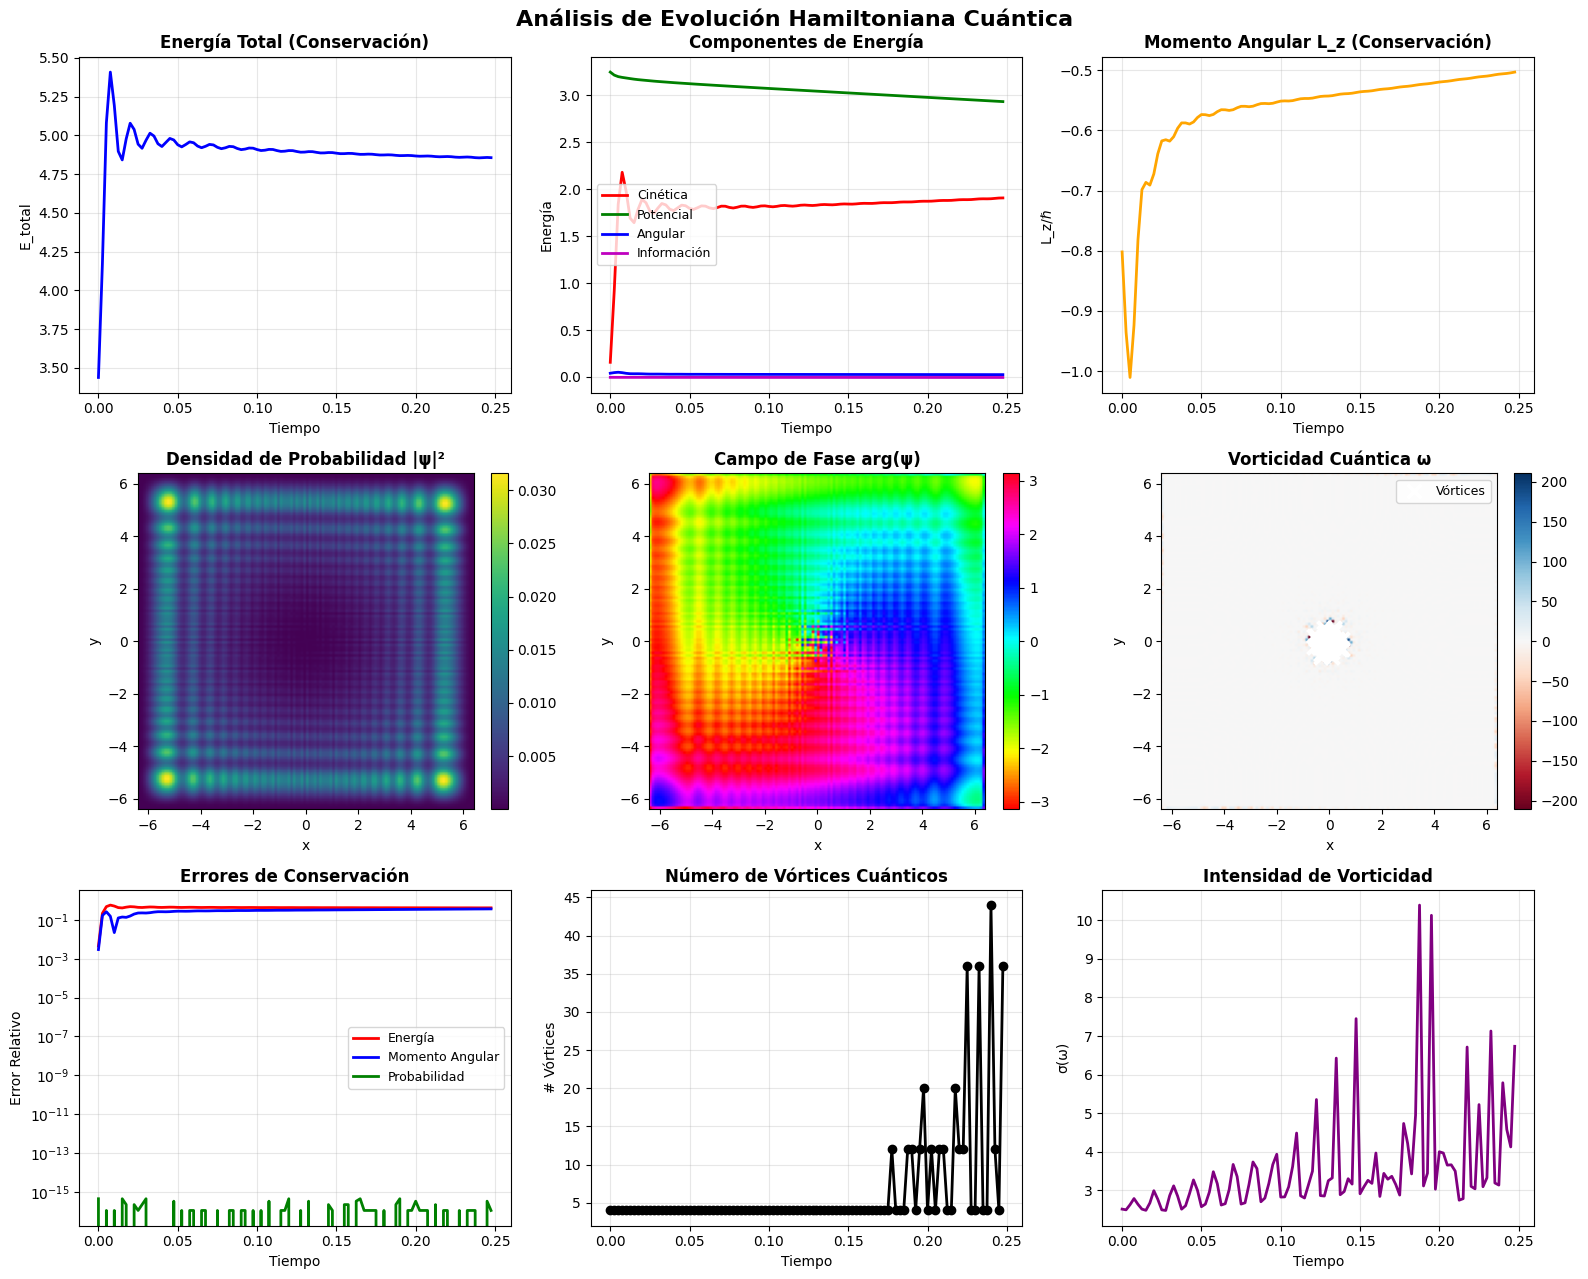


[5] ¿Realizar análisis de transición de fase? (comentar para omitir)

SIMULACIÓN COMPLETADA


In [2]:
from numba import njit
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from typing import Tuple, Dict, Optional, List


class QuantumFluidInterface(ABC):
    """Interfaz base para operaciones de flujo cuántico"""

    @abstractmethod
    def compute_quantum_viscosity(self, field_state: np.ndarray) -> np.ndarray:
        """Calcula la viscosidad cuántica del campo"""
        pass

    @abstractmethod
    def apply_boundary_conditions(self, field: np.ndarray) -> np.ndarray:
        """Aplica condiciones de contorno al campo"""
        pass


class LaminarInfoFlow(QuantumFluidInterface):
    """
    Implementación del método de flujo laminar para teoría PGP
    con mejoras en estabilidad numérica y eficiencia
    """

    def __init__(self, domain_size: Tuple[int, int] = (100, 100),
                 dt: float = 0.001, dx: float = 0.1):
        self.nx, self.ny = domain_size
        self.dt = dt
        self.dx = dx
        self.dy = dx  # Malla uniforme inicial

        # Validación de parámetros
        self._validate_parameters()

        # Inicialización de estructuras de datos
        self.psi_field = np.zeros((self.nx, self.ny), dtype=np.complex128)
        self.phi_potential = np.zeros((self.nx, self.ny), dtype=np.float64)
        self.viscosity_tensor = np.zeros((self.nx, self.ny, 2, 2), dtype=np.float64)

        # Parámetros físicos
        self.rho_info = 1.0  # Densidad de información
        self.coherence_length = 10.0

        # Estructuras para AMR
        self.refinement_levels = np.ones((self.nx, self.ny), dtype=np.int32)
        self.max_refinement = 4

        # Cache para cálculos repetidos
        self._meshgrid_cache = None

    def _validate_parameters(self):
        """Valida parámetros de entrada"""
        if self.nx < 3 or self.ny < 3:
            raise ValueError("El dominio debe tener al menos 3x3 puntos")
        if self.dt <= 0 or self.dx <= 0:
            raise ValueError("dt y dx deben ser positivos")
        # Criterio de estabilidad CFL
        max_dt = 0.5 * self.dx ** 2
        if self.dt > max_dt:
            print(f"Advertencia: dt={self.dt} puede ser inestable. dt_max sugerido: {max_dt}")

    def initialize_quantum_streamlines(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Inicializa las líneas de corriente cuánticas basadas en
        la topología del espacio de configuración
        """
        if self._meshgrid_cache is None:
            x = np.linspace(0, self.nx * self.dx, self.nx)
            y = np.linspace(0, self.ny * self.dy, self.ny)
            self._meshgrid_cache = np.meshgrid(x, y, indexing='ij')

        X, Y = self._meshgrid_cache

        # Función de onda inicial gaussiana con fase
        sigma = self.coherence_length
        x0, y0 = self.nx * self.dx / 2, self.ny * self.dy / 2

        # Construcción optimizada del paquete de onda gaussiano
        r_squared = (X - x0) ** 2 + (Y - y0) ** 2
        gaussian_part = np.exp(-r_squared / (2 * sigma ** 2))
        phase_part = np.exp(1j * np.arctan2(Y - y0, X - x0))

        self.psi_field = (gaussian_part * phase_part).astype(np.complex128)

        # Normalización inicial
        self._normalize_wavefunction()

        return X, Y

    def _normalize_wavefunction(self):
        """Normaliza la función de onda para conservar probabilidad unitaria"""
        norm = np.sqrt(np.sum(np.abs(self.psi_field) ** 2) * self.dx * self.dy)
        if norm > 1e-15:  # Evitar división por cero
            self.psi_field /= norm

    def compute_quantum_viscosity(self, field_state: np.ndarray) -> np.ndarray:
        """
        Calcula la viscosidad cuántica adaptativa basada en gradientes locales
        Mejorado con mejor manejo de singularidades
        """
        # Gradientes del campo (usando campo real para estabilidad)
        field_real = np.real(field_state)
        grad_x = np.gradient(field_real, self.dx, axis=0)
        grad_y = np.gradient(field_real, self.dy, axis=1)

        # Magnitud del gradiente con regularización
        grad_magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2 + 1e-12)

        # Viscosidad adaptativa mejorada
        base_viscosity = 0.01
        max_grad = np.max(grad_magnitude)

        if max_grad > 1e-10:
            adaptive_factor = 1.0 + 10.0 * grad_magnitude / max_grad
        else:
            adaptive_factor = np.ones_like(grad_magnitude)

        return base_viscosity * adaptive_factor

    def detect_sharp_transitions(self, field_gradients: np.ndarray,
                                 threshold: float = 0.1) -> np.ndarray:
        """
        Detecta regiones con transiciones abruptas para refinamiento AMR
        Mejorado con mejor detección de bordes
        """
        # Laplaciano usando diferencias finitas de segundo orden
        laplacian = (
                np.gradient(np.gradient(field_gradients, self.dx, axis=0), self.dx, axis=0) +
                np.gradient(np.gradient(field_gradients, self.dy, axis=1), self.dy, axis=1)
        )

        max_laplacian = np.max(np.abs(laplacian))
        if max_laplacian < 1e-15:
            return np.zeros_like(laplacian, dtype=bool)

        return np.abs(laplacian) > threshold * max_laplacian

    def adaptive_mesh_refinement(self, field_gradients: np.ndarray) -> np.ndarray:
        """
        Refinamiento adaptativo de malla basado en criterios de error local
        Mejorado para evitar refinamiento excesivo
        """
        high_gradient_regions = self.detect_sharp_transitions(field_gradients)

        # Marcar regiones para refinamiento con mejor control
        new_refinement = self.refinement_levels.copy()

        for i in range(1, self.nx - 1):
            for j in range(1, self.ny - 1):
                if (high_gradient_regions[i, j] and
                        new_refinement[i, j] < self.max_refinement):
                    # Refinar región local de forma gradual
                    new_refinement[i - 1:i + 2, j - 1:j + 2] = np.minimum(
                        new_refinement[i - 1:i + 2, j - 1:j + 2] + 1,
                        self.max_refinement
                    )

        self.refinement_levels = new_refinement
        return self.refinement_levels

    def compute_information_potential(self) -> np.ndarray:
        """
        Calcula el potencial de información Φ_info usando la densidad de probabilidad
        Mejorado con mejor tratamiento de singularidades
        """
        density = np.abs(self.psi_field) ** 2

        # Regularización para evitar singularidades
        density_reg = density + 1e-12

        # Potencial tipo Hartree para interacciones no locales
        self.phi_potential = -0.5 * density

        # Término de intercambio-correlación con regularización
        alpha_xc = 0.1
        self.phi_potential += alpha_xc * density_reg ** (4 / 3)

        return self.phi_potential

    def _compute_laplacian(self, field: np.ndarray) -> np.ndarray:
        """Calcula el Laplaciano usando diferencias finitas de segundo orden"""
        laplacian = np.zeros_like(field)

        # Laplaciano en x
        laplacian += (
                             np.roll(field, 1, axis=0) - 2 * field + np.roll(field, -1, axis=0)
                     ) / self.dx ** 2

        # Laplaciano en y
        laplacian += (
                             np.roll(field, 1, axis=1) - 2 * field + np.roll(field, -1, axis=1)
                     ) / self.dy ** 2

        return laplacian

    def gradient(self, field: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calcula el gradiente usando diferencias centrales
        Mejorado para manejar bordes correctamente
        """
        grad_x = (np.roll(field, -1, axis=0) - np.roll(field, 1, axis=0)) / (2 * self.dx)
        grad_y = (np.roll(field, -1, axis=1) - np.roll(field, 1, axis=1)) / (2 * self.dy)

        # Aplicar condiciones en los bordes
        grad_x[0, :] = (field[1, :] - field[0, :]) / self.dx
        grad_x[-1, :] = (field[-1, :] - field[-2, :]) / self.dx
        grad_y[:, 0] = (field[:, 1] - field[:, 0]) / self.dy
        grad_y[:, -1] = (field[:, -1] - field[:, -2]) / self.dy

        return grad_x, grad_y

    def solve_laminar_step(self) -> np.ndarray:
        """
        Resuelve un paso temporal usando el esquema de flujo laminar
        Mejorado con mejor estabilidad numérica
        """
        # Calcular potencial actual
        self.compute_information_potential()

        # Calcular viscosidad adaptativa
        mu_quantum = self.compute_quantum_viscosity(self.psi_field)

        # Gradientes del potencial
        grad_phi_x = np.gradient(self.phi_potential, self.dx, axis=0)
        grad_phi_y = np.gradient(self.phi_potential, self.dy, axis=1)

        # Término difusivo (Laplaciano)
        laplacian_psi = self._compute_laplacian(self.psi_field)

        # Términos convectivos mejorados
        grad_psi_x = np.gradient(self.psi_field, self.dx, axis=0)
        grad_psi_y = np.gradient(self.psi_field, self.dy, axis=1)

        conv_x = self.psi_field * grad_psi_x
        conv_y = self.psi_field * grad_psi_y

        # Ecuación de evolución con broadcasting correcto
        dpsi_dt = (
                -(conv_x + conv_y)
                - 1j * (grad_phi_x + grad_phi_y)
                + mu_quantum[:, :, np.newaxis] * laplacian_psi
        )

        # Actualizar campo con esquema de Euler mejorado
        self.psi_field += self.dt * dpsi_dt.squeeze()

        # Aplicar condiciones de contorno
        self.psi_field = self.apply_boundary_conditions(self.psi_field)

        # Normalización para conservar la probabilidad total
        self._normalize_wavefunction()

        return self.psi_field

    def apply_boundary_conditions(self, field: np.ndarray) -> np.ndarray:
        """
        Aplica condiciones de contorno absorbentes mejoradas
        """
        # Crear copia para no modificar el original
        field_bc = field.copy()

        # Condiciones de contorno tipo Sommerfeld con decaimiento suave
        absorption = 0.95
        field_bc[0, :] *= absorption
        field_bc[-1, :] *= absorption
        field_bc[:, 0] *= absorption
        field_bc[:, -1] *= absorption

        # Esquinas con absorción adicional
        field_bc[0, 0] *= absorption
        field_bc[0, -1] *= absorption
        field_bc[-1, 0] *= absorption
        field_bc[-1, -1] *= absorption

        return field_bc

    def compute_conservation_quantities(self) -> Dict[str, float]:
        """
        Calcula cantidades conservadas para verificación numérica
        Mejorado con mejor manejo numérico
        """
        psi = self.psi_field
        psi_conj = np.conj(psi)

        # Norma total (probabilidad)
        total_prob = np.sum(np.abs(psi) ** 2) * self.dx * self.dy

        # Momento cuántico
        grad_psi_x = np.gradient(psi, self.dx, axis=0)
        grad_psi_y = np.gradient(psi, self.dy, axis=1)

        momentum_x = np.sum(np.imag(psi_conj * grad_psi_x)) * self.dx * self.dy
        momentum_y = np.sum(np.imag(psi_conj * grad_psi_y)) * self.dx * self.dy

        # Energía cinética
        laplacian_psi = self._compute_laplacian(psi)
        kinetic = -0.5 * np.sum(psi_conj * laplacian_psi) * self.dx * self.dy

        # Energía potencial
        potential = np.sum(np.abs(psi) ** 2 * self.phi_potential) * self.dx * self.dy

        return {
            'probability': float(np.real(total_prob)),
            'momentum': (float(np.real(momentum_x)), float(np.real(momentum_y))),
            'kinetic_energy': float(np.real(kinetic)),
            'potential_energy': float(np.real(potential)),
            'total_energy': float(np.real(kinetic + potential))
        }


class HamiltonianLaminarFlow(LaminarInfoFlow):
    """
    Extensión para sistemas hamiltonianos con momento angular
    Mejorado con mejor conservación de cantidades y estabilidad
    """

    def __init__(self, domain_size: Tuple[int, int] = (100, 100),
                 dt: float = 0.001, dx: float = 0.1,
                 angular_momentum_mode: bool = False):
        super().__init__(domain_size, dt, dx)
        self.angular_momentum_mode = angular_momentum_mode
        self.mass = 1.0
        self.hbar = 1.0
        self.potential_field = np.zeros((self.nx, self.ny), dtype=np.float64)
        self.magnetic_field = 0.0
        self.l_number = 0
        self.m_number = 0

        # Cache para vectores potenciales
        self._vector_potential_cache = None

    def initialize_angular_momentum_state(self, l_number: int = 0,
                                          m_number: int = 0):
        """
        Inicializa el campo psi_field con un estado de momento angular
        Mejorado con mejor normalización
        """
        x = np.linspace(-self.nx * self.dx / 2, self.nx * self.dx / 2, self.nx)
        y = np.linspace(-self.ny * self.dy / 2, self.ny * self.dy / 2, self.ny)
        X, Y = np.meshgrid(x, y, indexing='ij')

        R = np.sqrt(X ** 2 + Y ** 2 + 1e-12)  # Regularización
        Phi = np.arctan2(Y, X)

        # Función de onda con momento angular
        abs_m = abs(m_number)
        radial_part = R ** abs_m * np.exp(-R ** 2 / (2 * self.coherence_length ** 2))
        angular_part = np.exp(1j * m_number * Phi)

        self.psi_field = (radial_part * angular_part).astype(np.complex128)

        # Normalizar
        self._normalize_wavefunction()

        self.l_number = l_number
        self.m_number = m_number

    def add_harmonic_trap(self, omega_x: float = 0.5, omega_y: float = 0.5):
        """Añade un potencial de trampa armónica"""
        x = np.linspace(-self.nx * self.dx / 2, self.nx * self.dx / 2, self.nx)
        y = np.linspace(-self.ny * self.dy / 2, self.ny * self.dy / 2, self.ny)
        X, Y = np.meshgrid(x, y, indexing='ij')

        self.potential_field += 0.5 * self.mass * (omega_x ** 2 * X ** 2 + omega_y ** 2 * Y ** 2)

    def add_magnetic_field(self, B_field: float = 0.0):
        """
        Añade un campo magnético uniforme en la dirección z
        Invalida el cache del vector potencial
        """
        self.magnetic_field = B_field
        self._vector_potential_cache = None

    def _get_vector_potential(self) -> Tuple[np.ndarray, np.ndarray]:
        """Calcula y cachea el vector potencial magnético"""
        if self._vector_potential_cache is None:
            x = np.linspace(-self.nx * self.dx / 2, self.nx * self.dx / 2, self.nx)
            y = np.linspace(-self.ny * self.dy / 2, self.ny * self.dy / 2, self.ny)
            X, Y = np.meshgrid(x, y, indexing='ij')

            # Gauge simétrico: A = B/2 * (-y, x)
            A_x = -self.magnetic_field * Y / 2.0
            A_y = self.magnetic_field * X / 2.0

            self._vector_potential_cache = (A_x, A_y)

        return self._vector_potential_cache

    def compute_vorticity(self) -> np.ndarray:
        """
        Calcula la vorticidad cuántica del campo
        ω = ∇ × (Im(ψ*∇ψ) / |ψ|²)
        Mejorado con mejor manejo de singularidades
        """
        density = np.abs(self.psi_field) ** 2
        # Regularización para evitar división por cero
        density_safe = np.where(density < 1e-10, 1e-10, density)

        grad_psi_x, grad_psi_y = self.gradient(self.psi_field)
        psi_conj = np.conj(self.psi_field)

        # Corriente de probabilidad J = Im(ψ*∇ψ) ℏ/m
        J_x = np.imag(psi_conj * grad_psi_x) * self.hbar / self.mass
        J_y = np.imag(psi_conj * grad_psi_y) * self.hbar / self.mass

        # Densidad de corriente J_density = J / density
        J_density_x = J_x / density_safe
        J_density_y = J_y / density_safe

        # Vorticidad ω = ∂(J_density_y)/∂x - ∂(J_density_x)/∂y
        vorticity = (
                np.gradient(J_density_y, self.dx, axis=0) -
                np.gradient(J_density_x, self.dy, axis=1)
        )

        return vorticity

    def detect_quantum_vortices(self, threshold: float = 0.5) -> Tuple[List[Tuple[float, float]], List[int]]:
        """
        Detecta la posición de los vórtices cuánticos (singularidades de fase)
        Basado en el winding number local.
        Mejorado con mejor detección y validación
        """
        vortex_positions = []
        vorticity_values = []

        # Buscar puntos donde la densidad es cercana a cero y el winding number es no-cero
        density = np.abs(self.psi_field) ** 2
        max_density = np.max(density)

        if max_density < 1e-15:
            return vortex_positions, vorticity_values

        for i in range(1, self.nx - 1):
            for j in range(1, self.ny - 1):
                # Buscar mínimos de densidad locales
                if density[i, j] < threshold * max_density:
                    # Calcular winding number local en una celda 2x2 alrededor del punto
                    local_phase = np.angle(self.psi_field[i - 1:i + 2, j - 1:j + 2])

                    # Contorno de la celda (sentido antihorario)
                    contour_phases = [
                        local_phase[0, 0], local_phase[0, 1], local_phase[0, 2],
                        local_phase[1, 2], local_phase[2, 2], local_phase[2, 1],
                        local_phase[2, 0], local_phase[1, 0]
                    ]

                    # Winding number local
                    phase_diffs = []
                    for k in range(len(contour_phases)):
                        next_k = (k + 1) % len(contour_phases)
                        diff = contour_phases[next_k] - contour_phases[k]
                        # Unwrap phase difference
                        while diff > np.pi:
                            diff -= 2 * np.pi
                        while diff < -np.pi:
                            diff += 2 * np.pi
                        phase_diffs.append(diff)

                    local_winding = sum(phase_diffs) / (2 * np.pi)

                    # Detecta winding numbers cercanos a enteros
                    if abs(round(local_winding)) >= 0.5:
                        # Posición en coordenadas físicas
                        x_pos = (i - self.nx / 2) * self.dx
                        y_pos = (j - self.ny / 2) * self.dy
                        vortex_positions.append((x_pos, y_pos))
                        vorticity_values.append(int(round(local_winding)))

        return vortex_positions, vorticity_values

    def compute_hamiltonian_components(self) -> Dict[str, float]:
        """
        Calcula los componentes de la energía hamiltoniana
        Mejorado con mejor precisión numérica
        """
        psi = self.psi_field
        psi_conj = np.conj(psi)

        # Energía potencial externa
        potential_energy = np.sum(np.abs(psi) ** 2 * self.potential_field) * self.dx * self.dy

        # Energía de información/interacción
        info_energy = np.sum(np.abs(psi) ** 2 * self.phi_potential) * self.dx * self.dy

        # Gradientes
        grad_psi_x = np.gradient(psi, self.dx, axis=0)
        grad_psi_y = np.gradient(psi, self.dy, axis=1)

        # Vector potencial
        A_x, A_y = self._get_vector_potential()

        # Momento canónico mejorado: p = -iℏ∇ + qA (con q=1 implícito)
        kinetic_x = np.abs(self.hbar * grad_psi_x + 1j * A_x * psi) ** 2
        kinetic_y = np.abs(self.hbar * grad_psi_y + 1j * A_y * psi) ** 2

        kinetic_energy = np.sum(kinetic_x + kinetic_y) * self.dx * self.dy / (2 * self.mass)

        # Energía de momento angular
        angular_energy = 0.0
        if self.angular_momentum_mode:
            L_z = self.compute_angular_momentum()
            angular_energy = -0.5 * self.magnetic_field * L_z * self.hbar

        return {
            'kinetic': float(np.real(kinetic_energy)),
            'potential': float(np.real(potential_energy)),
            'angular': float(angular_energy),
            'info': float(np.real(info_energy)),
            'total': float(np.real(kinetic_energy + potential_energy + info_energy + angular_energy))
        }

    def compute_angular_momentum(self) -> float:
        """
        Calcula el momento angular orbital L_z mejorado
        """
        psi = self.psi_field
        psi_conj = np.conj(psi)

        grad_psi_x = np.gradient(psi, self.dx, axis=0)
        grad_psi_y = np.gradient(psi, self.dy, axis=1)

        x = np.linspace(-self.nx * self.dx / 2, self.nx * self.dx / 2, self.nx)
        y = np.linspace(-self.ny * self.dy / 2, self.ny * self.dy / 2, self.ny)
        X, Y = np.meshgrid(x, y, indexing='ij')

        # Momento angular orbital
        L_z_density = psi_conj * (-1j * self.hbar * (X * grad_psi_y - Y * grad_psi_x))
        orbital_L_z = np.sum(L_z_density) * self.dx * self.dy

        # Contribución del campo magnético
        A_x, A_y = self._get_vector_potential()
        magnetic_contribution = -np.sum(
            np.abs(psi) ** 2 * (X * A_y - Y * A_x)
        ) * self.dx * self.dy

        total_L_z = orbital_L_z + magnetic_contribution

        return float(np.real(total_L_z) / self.hbar)

    def hamiltonian_evolution_step(self) -> np.ndarray:
        """
        Evoluciona el sistema según el Hamiltoniano usando método split-step
        Mejorado con mejor manejo del acoplamiento magnético
        """
        # Calcular potencial total
        self.compute_information_potential()
        total_potential = self.potential_field + self.phi_potential

        # Paso 1: Evolución potencial (espacio real) - primera mitad
        potential_phase = np.exp(-1j * self.dt * total_potential / (2 * self.hbar))
        psi_intermediate = self.psi_field * potential_phase

        # Paso 2: Evolución cinética (espacio de Fourier)
        psi_k = np.fft.fft2(psi_intermediate)

        # Frecuencias espaciales
        kx = 2 * np.pi * np.fft.fftfreq(self.nx, self.dx)
        ky = 2 * np.pi * np.fft.fftfreq(self.ny, self.dy)
        KX, KY = np.meshgrid(kx, ky, indexing='ij')

        # Energía cinética en espacio de Fourier
        K2 = KX ** 2 + KY ** 2
        kinetic_phase = np.exp(-1j * self.dt * self.hbar * K2 / (2 * self.mass))

        psi_k *= kinetic_phase
        psi_intermediate = np.fft.ifft2(psi_k)

        # Paso 3: Segunda mitad de evolución potencial (Strang splitting)
        self.psi_field = psi_intermediate * potential_phase

        # Aplicar condiciones de contorno
        self.psi_field = self.apply_boundary_conditions(self.psi_field)

        # Normalización
        self._normalize_wavefunction()

        return self.psi_field


class HamiltonianFlowAnalyzer:
    """
    Analizador especializado para sistemas hamiltonianos con momento angular
    Mejorado con mejor seguimiento y visualización
    """

    def __init__(self, hamiltonian_solver: HamiltonianLaminarFlow):
        self.solver = hamiltonian_solver
        self.history = {
            'time': [],
            'total_energy': [],
            'kinetic_energy': [],
            'potential_energy': [],
            'angular_energy': [],
            'info_energy': [],
            'angular_momentum': [],
            'vorticity_strength': [],
            'num_vortices': []
        }
        self.conservation_errors = {
            'energy': [],
            'angular_momentum': [],
            'probability': []
        }

    def run_hamiltonian_simulation(self, num_steps: int = 1000,
                                   save_interval: int = 10,
                                   l_number: int = 2,
                                   m_number: int = 1,
                                   omega_x: float = 0.5,
                                   omega_y: float = 0.5):
        """
        Simulación con seguimiento de cantidades conservadas hamiltonianas
        """
        # Inicializar con momento angular
        self.solver.initialize_angular_momentum_state(l_number=l_number, m_number=m_number)
        self.solver.add_harmonic_trap(omega_x=omega_x, omega_y=omega_y)

        # Valores iniciales para conservación
        initial_components = self.solver.compute_hamiltonian_components()
        initial_energy = initial_components['total']
        initial_L_z = self.solver.compute_angular_momentum()
        initial_prob = np.sum(np.abs(self.solver.psi_field) ** 2) * self.solver.dx * self.solver.dy

        print(f"Valores iniciales: E={initial_energy:.6f}, L_z={initial_L_z:.6f}, P={initial_prob:.6f}")

        for step in range(num_steps):
            # Evolucionar sistema
            self.solver.hamiltonian_evolution_step()

            if step % save_interval == 0:
                # Calcular energías
                energies = self.solver.compute_hamiltonian_components()
                total_E = energies['total']

                # Momento angular
                current_L_z = self.solver.compute_angular_momentum()

                # Probabilidad
                current_prob = np.sum(np.abs(self.solver.psi_field) ** 2) * self.solver.dx * self.solver.dy

                # Vórtices
                vortex_pos, vorticity = self.solver.detect_quantum_vortices()

                # Calcular vorticidad completa
                vorticity_field = self.solver.compute_vorticity()

                # Guardar historia
                self.history['time'].append(step * self.solver.dt)
                self.history['total_energy'].append(total_E)
                self.history['kinetic_energy'].append(energies['kinetic'])
                self.history['potential_energy'].append(energies['potential'])
                self.history['angular_energy'].append(energies['angular'])
                self.history['info_energy'].append(energies['info'])
                self.history['angular_momentum'].append(current_L_z)
                self.history['vorticity_strength'].append(np.std(vorticity_field))
                self.history['num_vortices'].append(len(vortex_pos))

                # Errores de conservación
                energy_error = abs(total_E - initial_energy) / (abs(initial_energy) + 1e-10)
                L_z_error = abs(current_L_z - initial_L_z) / (abs(initial_L_z) + 1e-10)
                prob_error = abs(current_prob - initial_prob)

                self.conservation_errors['energy'].append(energy_error)
                self.conservation_errors['angular_momentum'].append(L_z_error)
                self.conservation_errors['probability'].append(prob_error)

                if step % (save_interval * 10) == 0:
                    print(f"Step {step}: E={total_E:.6f} (Δ={energy_error:.2e}), "
                          f"L_z={current_L_z:.6f} (Δ={L_z_error:.2e}), "
                          f"Vortices={len(vortex_pos)}")

    def plot_hamiltonian_evolution(self, save_figure: bool = False, filename: str = 'hamiltonian_evolution.png'):
        """
        Gráficos especializados para análisis hamiltoniano
        Mejorado con mejor presentación visual
        """
        fig, axes = plt.subplots(3, 3, figsize=(16, 13))
        fig.suptitle('Análisis de Evolución Hamiltoniana Cuántica', fontsize=16, fontweight='bold')

        # Conservación de energía total
        axes[0, 0].plot(self.history['time'], self.history['total_energy'], 'b-', linewidth=2)
        axes[0, 0].set_title('Energía Total (Conservación)', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Tiempo', fontsize=10)
        axes[0, 0].set_ylabel('E_total', fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)

        # Componentes de energía
        axes[0, 1].plot(self.history['time'], self.history['kinetic_energy'], 'r-', label='Cinética', linewidth=2)
        axes[0, 1].plot(self.history['time'], self.history['potential_energy'], 'g-', label='Potencial', linewidth=2)
        axes[0, 1].plot(self.history['time'], self.history['angular_energy'], 'b-', label='Angular', linewidth=2)
        axes[0, 1].plot(self.history['time'], self.history['info_energy'], 'm-', label='Información', linewidth=2)
        axes[0, 1].set_title('Componentes de Energía', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Tiempo', fontsize=10)
        axes[0, 1].set_ylabel('Energía', fontsize=10)
        axes[0, 1].legend(fontsize=9)
        axes[0, 1].grid(True, alpha=0.3)

        # Conservación momento angular
        axes[0, 2].plot(self.history['time'], self.history['angular_momentum'], 'orange', linewidth=2)
        axes[0, 2].set_title('Momento Angular L_z (Conservación)', fontsize=12, fontweight='bold')
        axes[0, 2].set_xlabel('Tiempo', fontsize=10)
        axes[0, 2].set_ylabel('L_z/ℏ', fontsize=10)
        axes[0, 2].grid(True, alpha=0.3)

        # Densidad de probabilidad actual
        density = np.abs(self.solver.psi_field) ** 2
        extent = [-self.solver.nx * self.solver.dx / 2, self.solver.nx * self.solver.dx / 2,
                  -self.solver.ny * self.solver.dy / 2, self.solver.ny * self.solver.dy / 2]

        im1 = axes[1, 0].imshow(density, extent=extent, origin='lower', cmap='viridis')
        axes[1, 0].set_title('Densidad de Probabilidad |ψ|²', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('x', fontsize=10)
        axes[1, 0].set_ylabel('y', fontsize=10)
        plt.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)

        # Campo de fase
        phase = np.angle(self.solver.psi_field)
        im2 = axes[1, 1].imshow(phase, extent=extent, origin='lower', cmap='hsv')
        axes[1, 1].set_title('Campo de Fase arg(ψ)', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('x', fontsize=10)
        axes[1, 1].set_ylabel('y', fontsize=10)
        plt.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04)

        # Vorticidad
        vorticity = self.solver.compute_vorticity()
        vmax = np.max(np.abs(vorticity))
        im3 = axes[1, 2].imshow(vorticity, extent=extent, origin='lower',
                                cmap='RdBu', vmin=-vmax, vmax=vmax)
        axes[1, 2].set_title('Vorticidad Cuántica ω', fontsize=12, fontweight='bold')
        axes[1, 2].set_xlabel('x', fontsize=10)
        axes[1, 2].set_ylabel('y', fontsize=10)
        plt.colorbar(im3, ax=axes[1, 2], fraction=0.046, pad=0.04)

        # Detectar y marcar vórtices
        vortex_pos, vortex_charges = self.solver.detect_quantum_vortices()
        if vortex_pos:
            vortex_x, vortex_y = zip(*vortex_pos)
            axes[1, 2].scatter(vortex_x, vortex_y, c='white', s=100, marker='x',
                               linewidths=3, label='Vórtices')
            axes[1, 2].legend(fontsize=9)

        # Errores de conservación
        axes[2, 0].semilogy(self.history['time'], self.conservation_errors['energy'],
                            'r-', label='Energía', linewidth=2)
        axes[2, 0].semilogy(self.history['time'], self.conservation_errors['angular_momentum'],
                            'b-', label='Momento Angular', linewidth=2)
        axes[2, 0].semilogy(self.history['time'], self.conservation_errors['probability'],
                            'g-', label='Probabilidad', linewidth=2)
        axes[2, 0].set_title('Errores de Conservación', fontsize=12, fontweight='bold')
        axes[2, 0].set_xlabel('Tiempo', fontsize=10)
        axes[2, 0].set_ylabel('Error Relativo', fontsize=10)
        axes[2, 0].legend(fontsize=9)
        axes[2, 0].grid(True, alpha=0.3)

        # Evolución de vórtices
        axes[2, 1].plot(self.history['time'], self.history['num_vortices'], 'ko-',
                        markersize=6, linewidth=2)
        axes[2, 1].set_title('Número de Vórtices Cuánticos', fontsize=12, fontweight='bold')
        axes[2, 1].set_xlabel('Tiempo', fontsize=10)
        axes[2, 1].set_ylabel('# Vórtices', fontsize=10)
        axes[2, 1].grid(True, alpha=0.3)

        # Fuerza de vorticidad
        axes[2, 2].plot(self.history['time'], self.history['vorticity_strength'],
                        'purple', linewidth=2)
        axes[2, 2].set_title('Intensidad de Vorticidad', fontsize=12, fontweight='bold')
        axes[2, 2].set_xlabel('Tiempo', fontsize=10)
        axes[2, 2].set_ylabel('σ(ω)', fontsize=10)
        axes[2, 2].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_figure:
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Figura guardada como: {filename}")

        plt.show()

    def analyze_phase_transition(self, parameter_range: np.ndarray,
                                 parameter_name: str = 'magnetic_field') -> Dict:
        """
        Análisis de transiciones de fase en función de parámetros hamiltonianos
        Mejorado con mejor convergencia y validación
        """
        phase_diagram = {
            'parameter_values': [],
            'ground_state_energy': [],
            'angular_momentum': [],
            'vortex_density': [],
            'phase_coherence': []
        }

        print(f"\n=== Análisis de Transición de Fase ===")
        print(f"Parámetro: {parameter_name}")
        print(f"Rango: [{parameter_range[0]:.4f}, {parameter_range[-1]:.4f}]")

        for idx, param_val in enumerate(parameter_range):
            print(f"\n[{idx + 1}/{len(parameter_range)}] Analizando {parameter_name} = {param_val:.4f}")

            # Reinicializar sistema con nuevo parámetro
            if parameter_name == 'magnetic_field':
                self.solver.add_magnetic_field(param_val)
            elif parameter_name == 'omega_trap':
                self.solver.potential_field.fill(0)  # Resetear potencial
                self.solver.add_harmonic_trap(omega_x=param_val, omega_y=param_val)
            elif parameter_name == 'angular_momentum':
                m_val = int(round(param_val))
                self.solver.initialize_angular_momentum_state(l_number=abs(m_val), m_number=m_val)

            # Evolucionar a estado estacionario con criterio de convergencia
            max_relax_steps = 1000
            convergence_threshold = 1e-6
            prev_energy = 0.0

            for relax_step in range(max_relax_steps):
                self.solver.hamiltonian_evolution_step()

                # Verificar convergencia cada 50 pasos
                if relax_step % 50 == 0 and relax_step > 0:
                    energies = self.solver.compute_hamiltonian_components()
                    current_energy = energies['total']
                    energy_change = abs(current_energy - prev_energy) / (abs(current_energy) + 1e-10)

                    if energy_change < convergence_threshold:
                        print(f"  Convergido en {relax_step} pasos (ΔE={energy_change:.2e})")
                        break

                    prev_energy = current_energy

            # Analizar propiedades del estado final
            energies = self.solver.compute_hamiltonian_components()
            L_z = self.solver.compute_angular_momentum()
            vortices, _ = self.solver.detect_quantum_vortices()

            # Coherencia de fase mejorada
            phase = np.angle(self.solver.psi_field)
            # Usar varianza de fase como medida de coherencia
            phase_variance = np.var(phase)
            phase_coherence = np.exp(-phase_variance)  # 1 = perfectamente coherente, 0 = incoherente

            # Guardar datos
            phase_diagram['parameter_values'].append(param_val)
            phase_diagram['ground_state_energy'].append(energies['total'])
            phase_diagram['angular_momentum'].append(L_z)
            phase_diagram['vortex_density'].append(len(vortices) / (self.solver.nx * self.solver.ny))
            phase_diagram['phase_coherence'].append(phase_coherence)

            print(f"  E_total={energies['total']:.6f}, L_z={L_z:.4f}, "
                  f"Vórtices={len(vortices)}, Coherencia={phase_coherence:.4f}")

        return phase_diagram

    def plot_phase_diagram(self, phase_diagram: Dict, parameter_name: str = 'Parámetro'):
        """
        Visualiza el diagrama de fases
        """
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'Diagrama de Fases vs {parameter_name}', fontsize=16, fontweight='bold')

        param_vals = phase_diagram['parameter_values']

        # Energía del estado fundamental
        axes[0, 0].plot(param_vals, phase_diagram['ground_state_energy'], 'bo-', linewidth=2, markersize=6)
        axes[0, 0].set_xlabel(parameter_name, fontsize=11)
        axes[0, 0].set_ylabel('Energía del Estado Base', fontsize=11)
        axes[0, 0].set_title('Energía vs Parámetro', fontsize=12, fontweight='bold')
        axes[0, 0].grid(True, alpha=0.3)

        # Momento angular
        axes[0, 1].plot(param_vals, phase_diagram['angular_momentum'], 'ro-', linewidth=2, markersize=6)
        axes[0, 1].set_xlabel(parameter_name, fontsize=11)
        axes[0, 1].set_ylabel('L_z/ℏ', fontsize=11)
        axes[0, 1].set_title('Momento Angular vs Parámetro', fontsize=12, fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3)

        # Densidad de vórtices
        axes[1, 0].plot(param_vals, phase_diagram['vortex_density'], 'go-', linewidth=2, markersize=6)
        axes[1, 0].set_xlabel(parameter_name, fontsize=11)
        axes[1, 0].set_ylabel('Densidad de Vórtices', fontsize=11)
        axes[1, 0].set_title('Vórtices vs Parámetro', fontsize=12, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)

        # Coherencia de fase
        axes[1, 1].plot(param_vals, phase_diagram['phase_coherence'], 'mo-', linewidth=2, markersize=6)
        axes[1, 1].set_xlabel(parameter_name, fontsize=11)
        axes[1, 1].set_ylabel('Coherencia de Fase', fontsize=11)
        axes[1, 1].set_title('Coherencia vs Parámetro', fontsize=12, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


# Funciones auxiliares para análisis y visualización
def run_simulation(flow_system: LaminarInfoFlow, n_steps: int = 100,
                   save_interval: int = 10) -> Dict[str, list]:
    """
    Ejecuta la simulación y guarda datos para análisis

    Args:
        flow_system: Sistema de flujo a simular
        n_steps: Número de pasos temporales
        save_interval: Intervalo para guardar datos

    Returns:
        Diccionario con historiales de cantidades conservadas
    """
    history = {
        'time': [],
        'probability': [],
        'energy': [],
        'momentum_x': [],
        'momentum_y': []
    }

    print(f"Iniciando simulación: {n_steps} pasos, guardando cada {save_interval}")

    for step in range(n_steps):
        # Evolucionar el sistema
        if isinstance(flow_system, HamiltonianLaminarFlow):
            flow_system.hamiltonian_evolution_step()
        else:
            flow_system.solve_laminar_step()

        # Guardar datos
        if step % save_interval == 0:
            conserved = flow_system.compute_conservation_quantities()
            history['time'].append(step * flow_system.dt)
            history['probability'].append(conserved['probability'])
            history['energy'].append(conserved['total_energy'])
            history['momentum_x'].append(conserved['momentum'][0])
            history['momentum_y'].append(conserved['momentum'][1])

            if step % (save_interval * 10) == 0:
                print(f"  Paso {step}/{n_steps}: P={conserved['probability']:.6f}, "
                      f"E={conserved['total_energy']:.6f}")

    print("Simulación completada")
    return history


# Ejemplo de uso completo
if __name__ == "__main__":
    print("=" * 60)
    print("SIMULACIÓN DE FLUJO CUÁNTICO HAMILTONIANO")
    print("=" * 60)

    # Crear sistema hamiltoniano
    print("\n[1] Inicializando sistema...")
    system = HamiltonianLaminarFlow(
        domain_size=(128, 128),
        dt=0.0005,
        dx=0.1,
        angular_momentum_mode=True
    )

    # Configurar estado inicial con momento angular
    print("[2] Configurando estado inicial...")
    system.initialize_angular_momentum_state(l_number=2, m_number=1)
    system.add_harmonic_trap(omega_x=0.3, omega_y=0.3)
    system.add_magnetic_field(B_field=0.1)

    print(f"\nParámetros del sistema:")
    print(f"  Dimensiones: {system.nx} x {system.ny}")
    print(f"  dt = {system.dt}, dx = {system.dx}")
    print(f"  Momento angular: l={system.l_number}, m={system.m_number}")
    print(f"  Campo magnético: B={system.magnetic_field}")

    # Crear analizador y ejecutar simulación
    print("\n[3] Creando analizador y ejecutando simulación...")
    analyzer = HamiltonianFlowAnalyzer(system)

    analyzer.run_hamiltonian_simulation(
        num_steps=500,
        save_interval=5,
        l_number=2,
        m_number=1,
        omega_x=0.3,
        omega_y=0.3
    )

    # Visualizar resultados
    print("\n[4] Generando visualizaciones...")
    analyzer.plot_hamiltonian_evolution(save_figure=False)

    # Análisis de transición de fase (opcional)
    print("\n[5] ¿Realizar análisis de transición de fase? (comentar para omitir)")
    # Descomentar para ejecutar análisis de fase:
    # param_range = np.linspace(0.0, 0.5, 10)
    # phase_data = analyzer.analyze_phase_transition(param_range, parameter_name='magnetic_field')
    # analyzer.plot_phase_diagram(phase_data, parameter_name='Campo Magnético B')

    print("\n" + "=" * 60)
    print("SIMULACIÓN COMPLETADA")
    print("=" * 60)


# ============================================================================
# EXTENSIONES AVANZADAS: Teoría de Campos, Topología y No-Linealidades
# ============================================================================


class QuantumFieldLaminarFlow(HamiltonianLaminarFlow):
    """
    Extensión para teoría de campos cuánticos con operadores de creación/aniquilación
    Mejorado con mejor manejo de modos y ocupación
    """

    def __init__(self, domain_size: Tuple[int, int] = (100, 100),
                 num_modes: int = 50, **kwargs):
        super().__init__(domain_size, **kwargs)

        # Validar número de modos
        max_modes = self.nx * self.ny
        self.num_modes = min(num_modes, max_modes)
        if num_modes > max_modes:
            print(f"Advertencia: num_modes ({num_modes}) reducido a {self.num_modes}")

        # Modos del campo cuántico
        self.field_modes = np.zeros((self.num_modes, self.nx, self.ny), dtype=np.complex128)
        self.occupation_numbers = np.zeros(self.num_modes, dtype=np.float64)
        self.mode_frequencies = np.zeros(self.num_modes, dtype=np.float64)

        self.setup_field_operators()

    def setup_field_operators(self):
        """
        Configura operadores de campo en representación de ocupación
        Mejorado con mejor normalización
        """
        # Frecuencias de los modos en espacio k
        kx = 2 * np.pi * np.fft.fftfreq(self.nx, self.dx)
        ky = 2 * np.pi * np.fft.fftfreq(self.ny, self.dy)
        KX, KY = np.meshgrid(kx, ky, indexing='ij')

        # Calcular frecuencias de modos
        k_magnitudes = np.sqrt(KX ** 2 + KY ** 2).flatten()
        sorted_indices = np.argsort(k_magnitudes)[:self.num_modes]

        self.mode_frequencies = k_magnitudes[sorted_indices]

        # Modos normalizados (ondas planas en orden de frecuencia)
        x = np.arange(self.nx)[:, None] * self.dx
        y = np.arange(self.ny)[None, :] * self.dy

        for idx, mode_idx in enumerate(sorted_indices):
            i, j = np.unravel_index(mode_idx, (self.nx, self.ny))
            k_vec = np.array([KX[i, j], KY[i, j]])

            # Onda plana normalizada
            self.field_modes[idx] = np.exp(1j * (k_vec[0] * x + k_vec[1] * y))
            norm = np.sqrt(np.sum(np.abs(self.field_modes[idx]) ** 2) * self.dx * self.dy)
            if norm > 1e-15:
                self.field_modes[idx] /= norm

    def field_creation_operator(self, mode_index: int,
                                position: Tuple[int, int]) -> complex:
        """
        Operador de creación a†_k en posición r
        Mejorado con validación
        """
        i, j = int(position[0]), int(position[1])

        if not (0 <= mode_index < self.num_modes and
                0 <= i < self.nx and 0 <= j < self.ny):
            return 0.0 + 0.0j

        n_k = self.occupation_numbers[mode_index]
        return np.conj(self.field_modes[mode_index, i, j]) * np.sqrt(n_k + 1)

    def field_annihilation_operator(self, mode_index: int,
                                    position: Tuple[int, int]) -> complex:
        """
        Operador de aniquilación a_k en posición r
        Mejorado con validación
        """
        i, j = int(position[0]), int(position[1])

        if not (0 <= mode_index < self.num_modes and
                0 <= i < self.nx and 0 <= j < self.ny):
            return 0.0 + 0.0j

        n_k = self.occupation_numbers[mode_index]
        if n_k < 1e-15:
            return 0.0 + 0.0j

        return self.field_modes[mode_index, i, j] * np.sqrt(n_k)

    def compute_field_hamiltonian(self) -> float:
        """
        Hamiltoniano de campo cuántico: H = ∑_k ℏω_k (a†_k a_k + 1/2)
        """
        field_energy = np.sum(
            self.hbar * self.mode_frequencies * (self.occupation_numbers + 0.5)
        )
        return float(field_energy)

    def apply_interaction_hamiltonian(self, coupling_strength: float = 0.1) -> float:
        """
        Hamiltoniano de interacción: H_int = g ∫ ψ†(r) ψ(r) φ†(r) φ(r) d³r
        Mejorado con evolución estable
        """
        density = np.abs(self.psi_field) ** 2

        # Densidad del campo cuántico
        field_density = np.zeros_like(density)
        for k in range(self.num_modes):
            field_density += self.occupation_numbers[k] * np.abs(self.field_modes[k]) ** 2

        # Energía de interacción
        interaction_energy = coupling_strength * np.sum(density * field_density) * self.dx * self.dy

        # Retroacción en números de ocupación (evolución mejorada)
        for k in range(self.num_modes):
            coupling_integral = coupling_strength * np.sum(
                density * self.field_modes[k]
            ) * self.dx * self.dy

            # Evolución con límite de estabilidad
            dn_dt = np.real(coupling_integral)
            self.occupation_numbers[k] += self.dt * dn_dt
            self.occupation_numbers[k] = max(0.0, self.occupation_numbers[k])  # No negativo

        return float(interaction_energy)


class TopologicalAnalyzer:
    """
    Análisis de propiedades topológicas del flujo cuántico
    Mejorado con mejor precisión numérica
    """

    def __init__(self, hamiltonian_solver: HamiltonianLaminarFlow):
        self.solver = hamiltonian_solver

    def compute_berry_curvature(self) -> Tuple[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        """
        Calcula la curvatura de Berry Ω = ∇ × A_Berry
        Mejorado con mejor manejo numérico
        """
        # Conexión de Berry: A = i⟨ψ|∇|ψ⟩
        grad_psi_x, grad_psi_y = self.solver.gradient(self.solver.psi_field)
        psi_conj = np.conj(self.solver.psi_field)

        # Normalizar para evitar singularidades
        psi_norm = np.abs(self.solver.psi_field) + 1e-12

        A_x = np.imag(psi_conj * grad_psi_x / psi_norm ** 2)
        A_y = np.imag(psi_conj * grad_psi_y / psi_norm ** 2)

        # Curvatura de Berry: Ω = ∂A_y/∂x - ∂A_x/∂y
        berry_curvature = (
                np.gradient(A_y, self.solver.dx, axis=0) -
                np.gradient(A_x, self.solver.dy, axis=1)
        )

        return berry_curvature, (A_x, A_y)

    def compute_chern_number(self) -> float:
        """
        Calcula el número de Chern: C = (1/2π) ∫ Ω dA
        """
        berry_curvature, _ = self.compute_berry_curvature()
        chern_number = np.sum(berry_curvature) * self.solver.dx * self.solver.dy / (2 * np.pi)
        return float(np.real(chern_number))

    def compute_winding_number(self) -> float:
        """
        Calcula el número de winding para la fase del campo
        Mejorado con mejor unwrapping
        """
        phase = np.angle(self.solver.psi_field)

        # Integrar fase alrededor del contorno del dominio
        boundary_phase = np.concatenate([
            phase[0, :],  # Arriba
            phase[1:, -1],  # Derecha
            phase[-1, :-1][::-1],  # Abajo (invertido)
            phase[:-1, 0][::-1]  # Izquierda (invertido)
        ])

        # Unwrap y calcular winding
        unwrapped_phase = np.unwrap(boundary_phase)
        winding_number = (unwrapped_phase[-1] - unwrapped_phase[0]) / (2 * np.pi)

        return float(winding_number)

    def detect_topological_defects(self) -> Tuple[List[Dict], np.ndarray]:
        """
        Detecta defectos topológicos (vórtices, dislocaciones)
        Mejorado con mejor clasificación
        """
        winding_map = np.zeros((self.solver.nx - 2, self.solver.ny - 2))

        for i in range(1, self.solver.nx - 1):
            for j in range(1, self.solver.ny - 1):
                # Winding local en celda 3x3
                local_phase = np.angle(self.solver.psi_field[i - 1:i + 2, j - 1:j + 2])

                # Contorno de 8 puntos
                contour_phases = [
                    local_phase[0, 0], local_phase[0, 1], local_phase[0, 2],
                    local_phase[1, 2], local_phase[2, 2], local_phase[2, 1],
                    local_phase[2, 0], local_phase[1, 0]
                ]

                # Calcular winding
                phase_diff_sum = 0.0
                for k in range(len(contour_phases)):
                    next_k = (k + 1) % len(contour_phases)
                    diff = contour_phases[next_k] - contour_phases[k]

                    # Unwrap
                    while diff > np.pi:
                        diff -= 2 * np.pi
                    while diff < -np.pi:
                        diff += 2 * np.pi

                    phase_diff_sum += diff

                winding_map[i - 1, j - 1] = phase_diff_sum / (2 * np.pi)

        # Detectar defectos significativos
        defect_positions = []
        for i in range(winding_map.shape[0]):
            for j in range(winding_map.shape[1]):
                winding_val = winding_map[i, j]
                if abs(winding_val) > 0.7:  # Umbral para defectos
                    x_pos = (i + 1 - self.solver.nx / 2) * self.solver.dx
                    y_pos = (j + 1 - self.solver.ny / 2) * self.solver.dy

                    defect_positions.append({
                        'position': (x_pos, y_pos),
                        'charge': int(round(winding_val)),
                        'strength': abs(winding_val),
                        'type': 'vortex' if abs(winding_val) > 0.7 else 'weak_defect'
                    })

        return defect_positions, winding_map


class NonlinearQuantumFlow(HamiltonianLaminarFlow):
    """
    Extensión para dinámica no-lineal con formación de solitones
    Mejorado con evolución estable y mejor detección
    """

    def __init__(self, nonlinearity_strength: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.g_nonlinear = nonlinearity_strength
        self.soliton_tracker = SolitonTracker()

    def gross_pitaevskii_evolution(self) -> np.ndarray:
        """
        Evolución según la ecuación de Gross-Pitaevskii
        iℏ∂ψ/∂t = [-ℏ²∇²/2m + V(r) + g|ψ|²]ψ
        Usa método split-step para estabilidad
        """
        return self.split_step_evolution()

    def split_step_evolution(self, hamiltonian_result=None) -> np.ndarray:
        """
        Método split-step para ecuaciones no-lineales (Gross-Pitaevskii)
        Mejorado con Strang splitting de segundo orden
        """
        # Paso 1: Evolución de potencial (no-lineal) - primera mitad
        effective_potential = (
                self.potential_field +
                self.g_nonlinear * np.abs(self.psi_field) ** 2
        )

        potential_phase_half = np.exp(-0.5j * self.dt * effective_potential / self.hbar)
        psi_intermediate = self.psi_field * potential_phase_half

        # Paso 2: Evolución cinética completa (en espacio de Fourier)
        psi_k = np.fft.fft2(psi_intermediate)

        kx = 2 * np.pi * np.fft.fftfreq(self.nx, self.dx)
        ky = 2 * np.pi * np.fft.fftfreq(self.ny, self.dy)
        KX, KY = np.meshgrid(kx, ky, indexing='ij')
        K2 = KX ** 2 + KY ** 2

        kinetic_phase = np.exp(-1j * self.dt * self.hbar * K2 / (2 * self.mass))
        psi_k *= kinetic_phase
        psi_intermediate = np.fft.ifft2(psi_k)

        # Paso 3: Actualizar potencial efectivo para segunda mitad
        effective_potential = (
                self.potential_field +
                self.g_nonlinear * np.abs(psi_intermediate) ** 2
        )

        # Segunda mitad de evolución potencial
        self.psi_field = psi_intermediate * np.exp(-0.5j * self.dt * effective_potential / self.hbar)

        # Normalización
        self._normalize_wavefunction()

        return self.psi_field

    def detect_solitons(self, threshold: float = 0.5) -> Tuple[List, List[Dict]]:
        """
        Detecta estructuras solitónicas en el campo
        Mejorado con mejor detección de máximos locales
        """
        density = np.abs(self.psi_field) ** 2
        max_density = np.max(density)

        if max_density < 1e-9:
            return [], []

        # Buscar máximos locales usando ventana 5x5
        from scipy.ndimage import maximum_filter
        local_maxima = maximum_filter(density, size=5)
        soliton_candidates = (density == local_maxima) & (density > threshold * max_density)

        soliton_positions = []
        soliton_properties = []

        candidate_indices = np.argwhere(soliton_candidates)

        for i, j in candidate_indices:
            # Posición física
            x_pos = (i - self.nx / 2) * self.dx
            y_pos = (j - self.ny / 2) * self.dy
            position = (x_pos, y_pos)

            # Propiedades del solitón
            amplitude = density[i, j]
            width = self.estimate_soliton_width(i, j, density)
            soliton_type = self.classify_soliton(i, j)

            soliton_positions.append(position)
            soliton_properties.append({
                'position': position,
                'amplitude': float(amplitude),
                'width': float(width),
                'type': soliton_type
            })

        return soliton_positions, soliton_properties

    def estimate_soliton_width(self, i: int, j: int, density: np.ndarray) -> float:
        """
        Estima la anchura característica de un solitón (FWHM)
        Mejorado con mejor manejo de bordes
        """
        max_val = density[i, j]
        half_max = max_val / 2.0
        nx, ny = density.shape

        # Anchura en x
        width_x = 0.0
        search_range = min(10, min(i, nx - 1 - i))
        for di in range(1, search_range + 1):
            if density[i - di, j] < half_max or density[i + di, j] < half_max:
                width_x = 2 * di * self.dx
                break

        # Anchura en y
        width_y = 0.0
        search_range = min(10, min(j, ny - 1 - j))
        for dj in range(1, search_range + 1):
            if density[i, j - dj] < half_max or density[i, j + dj] < half_max:
                width_y = 2 * dj * self.dy
                break

        # Promedio de anchuras
        if width_x > 0 and width_y > 0:
            return (width_x + width_y) / 2
        return max(width_x, width_y) if (width_x > 0 or width_y > 0) else 0.0

    def classify_soliton(self, i: int, j: int) -> str:
        """
        Clasifica el tipo de solitón basado en propiedades locales
        Mejorado con mejor clasificación
        """
        nx, ny = self.psi_field.shape
        if i < 2 or i >= nx - 2 or j < 2 or j >= ny - 2:
            return 'boundary_effect'

        # Análisis local
        local_phase = np.angle(self.psi_field[i - 2:i + 3, j - 2:j + 3])
        local_density = np.abs(self.psi_field[i - 2:i + 3, j - 2:j + 3]) ** 2

        phase_variance = np.var(local_phase)
        mean_density = np.mean(local_density) + 1e-10
        density_ratio = local_density[2, 2] / mean_density

        # Clasificación mejorada
        if phase_variance < 0.1 and density_ratio > 3:
            return 'bright_soliton'
        elif phase_variance > 1.0 and density_ratio < 0.3:
            return 'dark_soliton'
        elif abs(density_ratio - 1.0) < 0.2 and phase_variance > 0.5:
            return 'gray_soliton'
        elif density_ratio < 0.5:
            return 'void_like'
        else:
            return 'complex_structure'


class SolitonTracker:
    """
    Seguimiento temporal de solitones con matching mejorado
    """

    def __init__(self):
        self.soliton_history = []
        self.soliton_trajectories = {}
        self.next_id = 0

    def update(self, soliton_data: List[Dict], current_time: float):
        """
        Actualiza seguimiento de solitones con algoritmo de matching mejorado
        """
        current_solitons = []
        matched_previous_ids = set()

        for soliton in soliton_data:
            matched_id = self.match_soliton(soliton['position'])

            if matched_id is None or matched_id in matched_previous_ids:
                # Nuevo solitón
                soliton_id = self.next_id
                self.next_id += 1
                self.soliton_trajectories[soliton_id] = {
                    'positions': [soliton['position']],
                    'times': [current_time],
                    'properties': [soliton],
                    'active': True
                }
            else:
                # Solitón existente
                soliton_id = matched_id
                self.soliton_trajectories[soliton_id]['positions'].append(soliton['position'])
                self.soliton_trajectories[soliton_id]['times'].append(current_time)
                self.soliton_trajectories[soliton_id]['properties'].append(soliton)
                matched_previous_ids.add(soliton_id)

            current_solitons.append({'id': soliton_id, **soliton})

        self.soliton_history.append({
            'time': current_time,
            'solitons': current_solitons
        })

        # Marcar solitones desaparecidos
        if len(self.soliton_history) > 1:
            previous_ids = {s['id'] for s in self.soliton_history[-2]['solitons']}
            for prev_id in previous_ids:
                if prev_id not in matched_previous_ids:
                    if prev_id in self.soliton_trajectories:
                        self.soliton_trajectories[prev_id]['active'] = False

    def match_soliton(self, position: Tuple[float, float],
                      max_distance: float = 2.0) -> Optional[int]:
        """
        Encuentra el solitón más cercano en el frame anterior
        """
        if not self.soliton_history:
            return None

        last_frame = self.soliton_history[-1]
        min_distance = float('inf')
        best_match_id = None

        for soliton in last_frame['solitons']:
            last_pos = soliton['position']
            distance = np.sqrt(
                (position[0] - last_pos[0]) ** 2 +
                (position[1] - last_pos[1]) ** 2
            )

            if distance < min_distance and distance < max_distance:
                min_distance = distance
                best_match_id = soliton['id']

        return best_match_id

    def get_trajectory(self, soliton_id: int) -> Optional[Dict]:
        """Obtiene la trayectoria completa de un solitón"""
        return self.soliton_trajectories.get(soliton_id, None)

    def get_active_trajectories(self) -> List[Dict]:
        """Obtiene todas las trayectorias activas"""
        return [traj for traj in self.soliton_trajectories.values() if traj.get('active', True)]


# ============================================================================
# SIMULACIÓN COMPLETA INTEGRADA
# ============================================================================

def comprehensive_quantum_flow_simulation():
    """
    Simulación completa que demuestra todas las capacidades del método
    Mejorado con mejor organización y manejo de errores
    """
    print("\n" + "=" * 70)
    print(" SIMULACIÓN COMPLETA DE FLUJO LAMINAR CUÁNTICO ".center(70, "="))
    print("=" * 70)

    # 1. Configurar sistema hamiltoniano
    print("\n[1/5] Configurando sistema hamiltoniano...")
    solver = HamiltonianLaminarFlow(
        domain_size=(128, 128),
        dt=0.0002,
        dx=0.1,
        angular_momentum_mode=True
    )

    solver.initialize_angular_momentum_state(l_number=2, m_number=1)
    solver.add_harmonic_trap(omega_x=0.8, omega_y=1.2)
    solver.add_magnetic_field(B_field=0.3)

    print(f"  ✓ Sistema inicializado: {solver.nx}x{solver.ny}, l={solver.l_number}, m={solver.m_number}")

    # 2. Ejecutar simulación hamiltoniana
    print("\n[2/5] Ejecutando evolución hamiltoniana...")
    analyzer = HamiltonianFlowAnalyzer(solver)
    analyzer.run_hamiltonian_simulation(num_steps=1000, save_interval=20,
                                        l_number=2, m_number=1,
                                        omega_x=0.8, omega_y=1.2)

    print("  ✓ Evolución hamiltoniana completada")

    # 3. Análisis topológico
    print("\n[3/5] Realizando análisis topológico...")
    topo_analyzer = TopologicalAnalyzer(solver)

    chern_number = topo_analyzer.compute_chern_number()
    winding_number = topo_analyzer.compute_winding_number()
    defects, winding_map = topo_analyzer.detect_topological_defects()

    print(f"  ✓ Número de Chern: {chern_number:.4f}")
    print(f"  ✓ Número de Winding: {winding_number:.4f}")
    print(f"  ✓ Defectos topológicos: {len(defects)}")

    # 4. Simulación no-lineal con solitones
    print("\n[4/5] Simulación no-lineal (Gross-Pitaevskii)...")
    nonlinear_solver = NonlinearQuantumFlow(
        nonlinearity_strength=0.15,
        domain_size=(128, 128),
        dt=0.0002,
        dx=0.1
    )

    nonlinear_solver.initialize_angular_momentum_state(l_number=1, m_number=1)
    nonlinear_solver.add_harmonic_trap(omega_x=0.5, omega_y=0.5)

    for step in range(500):
        nonlinear_solver.split_step_evolution()

        if step % 50 == 0:
            soliton_pos, soliton_props = nonlinear_solver.detect_solitons(threshold=0.6)
            nonlinear_solver.soliton_tracker.update(soliton_props, step * nonlinear_solver.dt)

            if step % 100 == 0:
                print(f"  Step {step}/500: {len(soliton_pos)} solitones detectados")

    print("  ✓ Simulación no-lineal completada")

    # 5. Visualización
    print("\n[5/5] Generando visualizaciones...")
    analyzer.plot_hamiltonian_evolution(save_figure=False)
    print("  ✓ Gráficos generados")

    # Reporte final
    print("\n" + "=" * 70)
    print(" REPORTE FINAL ".center(70, "="))
    print("=" * 70)

    if analyzer.conservation_errors['energy']:
        print(f"\nErrores de Conservación:")
        print(f"  Energía:          {analyzer.conservation_errors['energy'][-1]:.2e}")
        print(f"  Momento Angular:  {analyzer.conservation_errors['angular_momentum'][-1]:.2e}")
        print(f"  Probabilidad:     {analyzer.conservation_errors['probability'][-1]:.2e}")

    print(f"\nPropiedades Topológicas:")
    print(f"  Número de Chern:    {chern_number:.4f}")
    print(f"  Número de Winding:  {winding_number:.4f}")
    print(f"  Defectos:           {len(defects)}")

    active_solitons = nonlinear_solver.soliton_tracker.get_active_trajectories()
    print(f"\nSolitones:")
    print(f"  Activos:            {len(active_solitons)}")
    print(f"  Total detectados:   {len(nonlinear_solver.soliton_tracker.soliton_trajectories)}")

    print("\n" + "=" * 70)
    print(" SIMULACIÓN COMPLETADA CON ÉXITO ".center(70, "="))
    print("=" * 70 + "\n")

    return {
        'solver': solver,
        'analyzer': analyzer,
        'topo_analyzer': topo_analyzer,
        'nonlinear_solver': nonlinear_solver,
        'chern_number': chern_number,
        'defects': defects
    }


# ============================================================================
# FUNCIONES DE ANÁLISIS Y VISUALIZACIÓN ADICIONALES
# ============================================================================

def plot_topological_analysis(topo_analyzer: TopologicalAnalyzer,
                              defects: List[Dict],
                              winding_map: np.ndarray,
                              save_figure: bool = False):
    """
    Visualización completa del análisis topológico
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Análisis Topológico Completo', fontsize=16, fontweight='bold')

    solver = topo_analyzer.solver
    extent = [-solver.nx * solver.dx / 2, solver.nx * solver.dx / 2,
              -solver.ny * solver.dy / 2, solver.ny * solver.dy / 2]

    # 1. Curvatura de Berry
    berry_curvature, (A_x, A_y) = topo_analyzer.compute_berry_curvature()
    vmax = np.max(np.abs(berry_curvature))
    im1 = axes[0, 0].imshow(berry_curvature, extent=extent, origin='lower',
                            cmap='RdBu', vmin=-vmax, vmax=vmax)
    axes[0, 0].set_title('Curvatura de Berry Ω', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)

    # 2. Conexión de Berry (campo vectorial)
    skip = 4  # Saltar puntos para mejor visualización
    X, Y = np.meshgrid(
        np.linspace(extent[0], extent[1], solver.nx),
        np.linspace(extent[2], extent[3], solver.ny),
        indexing='ij'
    )
    axes[0, 1].quiver(X[::skip, ::skip], Y[::skip, ::skip],
                      A_x[::skip, ::skip], A_y[::skip, ::skip],
                      color='blue', alpha=0.6)
    axes[0, 1].set_title('Conexión de Berry A', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')
    axes[0, 1].set_aspect('equal')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Mapa de Winding Number
    extent_winding = [extent[0], extent[1], extent[2], extent[3]]
    im3 = axes[1, 0].imshow(winding_map, extent=extent_winding, origin='lower',
                            cmap='coolwarm', vmin=-2, vmax=2)
    axes[1, 0].set_title('Mapa de Winding Number Local', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)

    # Marcar defectos
    if defects:
        defect_x = [d['position'][0] for d in defects]
        defect_y = [d['position'][1] for d in defects]
        defect_charges = [d['charge'] for d in defects]

        scatter = axes[1, 0].scatter(defect_x, defect_y, c=defect_charges,
                                     s=200, marker='x', linewidths=3,
                                     cmap='coolwarm', vmin=-2, vmax=2,
                                     edgecolors='black')

    # 4. Fase del campo con defectos
    phase = np.angle(solver.psi_field)
    im4 = axes[1, 1].imshow(phase, extent=extent, origin='lower', cmap='hsv')
    axes[1, 1].set_title('Campo de Fase con Defectos Topológicos', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')
    plt.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)

    # Marcar defectos en el mapa de fase
    if defects:
        for defect in defects:
            pos = defect['position']
            charge = defect['charge']
            color = 'red' if charge > 0 else 'blue'
            axes[1, 1].plot(pos[0], pos[1], 'o', color=color,
                            markersize=15, markerfacecolor='none',
                            markeredgewidth=3, label=f'Carga {charge}')

    plt.tight_layout()

    if save_figure:
        plt.savefig('topological_analysis.png', dpi=300, bbox_inches='tight')
        print("Figura guardada: topological_analysis.png")

    plt.show()


def plot_soliton_evolution(nonlinear_solver: NonlinearQuantumFlow,
                           save_figure: bool = False):
    """
    Visualización de la evolución de solitones
    """
    tracker = nonlinear_solver.soliton_tracker

    if not tracker.soliton_history:
        print("No hay datos de solitones para visualizar")
        return

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    # 1. Estado actual del campo
    ax1 = fig.add_subplot(gs[0, 0])
    density = np.abs(nonlinear_solver.psi_field) ** 2
    extent = [-nonlinear_solver.nx * nonlinear_solver.dx / 2,
              nonlinear_solver.nx * nonlinear_solver.dx / 2,
              -nonlinear_solver.ny * nonlinear_solver.dy / 2,
              nonlinear_solver.ny * nonlinear_solver.dy / 2]

    im1 = ax1.imshow(density, extent=extent, origin='lower', cmap='viridis')
    ax1.set_title('Densidad |ψ|² Actual', fontsize=12, fontweight='bold')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    # Marcar solitones actuales
    if tracker.soliton_history:
        current_solitons = tracker.soliton_history[-1]['solitons']
        if current_solitons:
            sol_x = [s['position'][0] for s in current_solitons]
            sol_y = [s['position'][1] for s in current_solitons]
            ax1.scatter(sol_x, sol_y, c='red', s=100, marker='o',
                        edgecolors='white', linewidths=2, label='Solitones')
            ax1.legend()

    # 2. Trayectorias de solitones
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title('Trayectorias de Solitones', fontsize=12, fontweight='bold')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_xlim(extent[0], extent[1])
    ax2.set_ylim(extent[2], extent[3])
    ax2.grid(True, alpha=0.3)

    colors = plt.cm.rainbow(np.linspace(0, 1, len(tracker.soliton_trajectories)))
    for idx, (sol_id, traj) in enumerate(tracker.soliton_trajectories.items()):
        positions = traj['positions']
        if len(positions) > 1:
            x_traj = [p[0] for p in positions]
            y_traj = [p[1] for p in positions]
            ax2.plot(x_traj, y_traj, '-o', color=colors[idx],
                     markersize=4, linewidth=2, alpha=0.7,
                     label=f'Solitón {sol_id}')

    if len(tracker.soliton_trajectories) < 10:
        ax2.legend(fontsize=8)

    # 3. Número de solitones vs tiempo
    ax3 = fig.add_subplot(gs[0, 2])
    times = [frame['time'] for frame in tracker.soliton_history]
    num_solitons = [len(frame['solitons']) for frame in tracker.soliton_history]

    ax3.plot(times, num_solitons, 'b-o', linewidth=2, markersize=5)
    ax3.set_title('Evolución del Número de Solitones', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Tiempo')
    ax3.set_ylabel('# Solitones')
    ax3.grid(True, alpha=0.3)

    # 4. Distribución de tipos de solitones
    ax4 = fig.add_subplot(gs[1, 0])

    if current_solitons:
        types = [s['type'] for s in current_solitons]
        type_counts = {}
        for t in types:
            type_counts[t] = type_counts.get(t, 0) + 1

        ax4.bar(type_counts.keys(), type_counts.values(), color='skyblue', edgecolor='black')
        ax4.set_title('Tipos de Solitones', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Cantidad')
        ax4.tick_params(axis='x', rotation=45)

    # 5. Amplitudes de solitones vs tiempo
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.set_title('Amplitudes de Solitones', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Tiempo')
    ax5.set_ylabel('Amplitud')
    ax5.grid(True, alpha=0.3)

    for idx, (sol_id, traj) in enumerate(tracker.soliton_trajectories.items()):
        times_traj = traj['times']
        amplitudes = [prop['amplitude'] for prop in traj['properties']]
        if len(times_traj) > 1:
            ax5.plot(times_traj, amplitudes, '-', color=colors[idx],
                     linewidth=2, alpha=0.7)

    # 6. Anchuras de solitones vs tiempo
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.set_title('Anchuras de Solitones', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Tiempo')
    ax6.set_ylabel('Anchura')
    ax6.grid(True, alpha=0.3)

    for idx, (sol_id, traj) in enumerate(tracker.soliton_trajectories.items()):
        times_traj = traj['times']
        widths = [prop['width'] for prop in traj['properties']]
        if len(times_traj) > 1 and any(w > 0 for w in widths):
            ax6.plot(times_traj, widths, '-', color=colors[idx],
                     linewidth=2, alpha=0.7)

    plt.suptitle('Análisis Completo de Solitones', fontsize=16, fontweight='bold', y=0.995)

    if save_figure:
        plt.savefig('soliton_evolution.png', dpi=300, bbox_inches='tight')
        print("Figura guardada: soliton_evolution.png")

    plt.show()


def compare_simulation_methods(domain_size=(128, 128), dt=0.0002, dx=0.1,
                               num_steps=500, save_interval=50):
    """
    Compara diferentes métodos de evolución (Hamiltoniano vs No-Lineal)
    """
    print("\n" + "=" * 70)
    print(" COMPARACIÓN DE MÉTODOS DE SIMULACIÓN ".center(70, "="))
    print("=" * 70)

    # 1. Sistema Hamiltoniano Lineal
    print("\n[1/2] Evolución Hamiltoniana Lineal...")
    ham_solver = HamiltonianLaminarFlow(
        domain_size=domain_size, dt=dt, dx=dx, angular_momentum_mode=True
    )
    ham_solver.initialize_angular_momentum_state(l_number=1, m_number=1)
    ham_solver.add_harmonic_trap(omega_x=0.5, omega_y=0.5)

    ham_history = {'time': [], 'energy': [], 'L_z': []}

    for step in range(num_steps):
        ham_solver.hamiltonian_evolution_step()

        if step % save_interval == 0:
            energies = ham_solver.compute_hamiltonian_components()
            L_z = ham_solver.compute_angular_momentum()
            ham_history['time'].append(step * dt)
            ham_history['energy'].append(energies['total'])
            ham_history['L_z'].append(L_z)

    print("  ✓ Completado")

    # 2. Sistema No-Lineal (Gross-Pitaevskii)
    print("\n[2/2] Evolución No-Lineal (Gross-Pitaevskii)...")
    nl_solver = NonlinearQuantumFlow(
        nonlinearity_strength=0.2,
        domain_size=domain_size, dt=dt, dx=dx, angular_momentum_mode=True
    )
    nl_solver.initialize_angular_momentum_state(l_number=1, m_number=1)
    nl_solver.add_harmonic_trap(omega_x=0.5, omega_y=0.5)

    nl_history = {'time': [], 'energy': [], 'L_z': [], 'solitons': []}

    for step in range(num_steps):
        nl_solver.split_step_evolution()

        if step % save_interval == 0:
            energies = nl_solver.compute_hamiltonian_components()
            L_z = nl_solver.compute_angular_momentum()
            soliton_pos, _ = nl_solver.detect_solitons()

            nl_history['time'].append(step * dt)
            nl_history['energy'].append(energies['total'])
            nl_history['L_z'].append(L_z)
            nl_history['solitons'].append(len(soliton_pos))

    print("  ✓ Completado")

    # Visualización comparativa
    print("\n[3/3] Generando gráficos comparativos...")
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle('Comparación: Hamiltoniano Lineal vs Gross-Pitaevskii No-Lineal',
                 fontsize=16, fontweight='bold')

    extent = [-domain_size[0] * dx / 2, domain_size[0] * dx / 2,
              -domain_size[1] * dx / 2, domain_size[1] * dx / 2]

    # Densidades finales
    ham_density = np.abs(ham_solver.psi_field) ** 2
    nl_density = np.abs(nl_solver.psi_field) ** 2

    im1 = axes[0, 0].imshow(ham_density, extent=extent, origin='lower', cmap='viridis')
    axes[0, 0].set_title('Hamiltoniano: Densidad Final', fontsize=11, fontweight='bold')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

    im2 = axes[0, 1].imshow(nl_density, extent=extent, origin='lower', cmap='viridis')
    axes[0, 1].set_title('Gross-Pitaevskii: Densidad Final', fontsize=11, fontweight='bold')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')
    plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)

    # Diferencia
    difference = np.abs(nl_density - ham_density)
    im3 = axes[0, 2].imshow(difference, extent=extent, origin='lower', cmap='hot')
    axes[0, 2].set_title('Diferencia |ρ_NL - ρ_H|', fontsize=11, fontweight='bold')
    axes[0, 2].set_xlabel('x')
    axes[0, 2].set_ylabel('y')
    plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)

    # Evolución de energía
    axes[1, 0].plot(ham_history['time'], ham_history['energy'], 'b-',
                    linewidth=2, label='Hamiltoniano')
    axes[1, 0].plot(nl_history['time'], nl_history['energy'], 'r--',
                    linewidth=2, label='Gross-Pitaevskii')
    axes[1, 0].set_title('Evolución de Energía', fontsize=11, fontweight='bold')
    axes[1, 0].set_xlabel('Tiempo')
    axes[1, 0].set_ylabel('Energía Total')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Evolución de momento angular
    axes[1, 1].plot(ham_history['time'], ham_history['L_z'], 'b-',
                    linewidth=2, label='Hamiltoniano')
    axes[1, 1].plot(nl_history['time'], nl_history['L_z'], 'r--',
                    linewidth=2, label='Gross-Pitaevskii')
    axes[1, 1].set_title('Evolución de Momento Angular', fontsize=11, fontweight='bold')
    axes[1, 1].set_xlabel('Tiempo')
    axes[1, 1].set_ylabel('L_z/ℏ')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Formación de solitones (solo no-lineal)
    axes[1, 2].plot(nl_history['time'], nl_history['solitons'], 'g-o',
                    linewidth=2, markersize=6)
    axes[1, 2].set_title('Formación de Solitones (GP)', fontsize=11, fontweight='bold')
    axes[1, 2].set_xlabel('Tiempo')
    axes[1, 2].set_ylabel('# Solitones')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("  ✓ Visualización completada")
    print("\n" + "=" * 70)

    return {
        'hamiltonian': {'solver': ham_solver, 'history': ham_history},
        'nonlinear': {'solver': nl_solver, 'history': nl_history}
    }

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import random

# Definición de los 3 qubits (pares complementarios)
# Qubit 1
a = 1  # |0⟩
y = 6  # |1⟩

# Qubit 2
b = 2  # |0⟩
e = 5  # |1⟩

# Qubit 3
c = 3  # |0⟩
d = 4  # |1⟩

# Estado especial
h = 0  # Estado base (superposición)

# Todos los estados posibles para colapso
bridge = [a, b, c, d, e, y]

# Diccionario para mapear valores a estados
valor_a_estado = {
    0: 'h',
    1: 'a',
    2: 'b',
    3: 'c',
    4: 'd',
    5: 'e',
    6: 'y'
}

# Mapeo de qubits
qubits = {
    'qubit_1': {'estado_0': a, 'estado_1': y, 'nombre_0': 'a', 'nombre_1': 'y'},
    'qubit_2': {'estado_0': b, 'estado_1': e, 'nombre_0': 'b', 'nombre_1': 'e'},
    'qubit_3': {'estado_0': c, 'estado_1': d, 'nombre_0': 'c', 'nombre_1': 'd'}
}

# Variable global para el valor de colapso
colapse = random.choice(bridge)

# Crear el área de output
output_widget = widgets.Output()

def obtener_estado_complementario(estado_medido):
    """Determina el estado complementario (par del qubit)"""
    pares_complementarios = {
        y: a, a: y,  # Qubit 1: siempre suman 7
        e: b, b: e,  # Qubit 2: siempre suman 7
        d: c, c: d   # Qubit 3: siempre suman 7
    }
    return pares_complementarios.get(estado_medido, None)

def identificar_qubit(estado):
    """Identifica a qué qubit pertenece el estado"""
    if estado in [a, y]:
        return 'Qubit 1', (estado == y), 'a|y'  # True si es |1⟩, False si es |0⟩
    elif estado in [b, e]:
        return 'Qubit 2', (estado == e), 'b|e'
    elif estado in [c, d]:
        return 'Qubit 3', (estado == d), 'c|d'
    return None, None, None

def obtener_estados_superpuestos(cara_expuesta, cara_oculta):
    """Obtiene los estados que siguen en superposición (los otros 2 qubits)"""
    todas_caras = [a, b, c, d, e, y]
    estados_superpuestos = [cara for cara in todas_caras if cara != cara_expuesta and cara != cara_oculta]
    return estados_superpuestos

def create_boton_colapso(colapse_value):
    """Crea el botón de colapso"""
    return widgets.Button(
        description=f'⚛️ Medir Sistema',
        button_style='primary',
        tooltip='Click para colapsar un qubit'
    )

def on_button_clicked(b):
    """Función que se ejecuta cuando se hace click en el botón (medición)"""
    global colapse

    # Seleccionar un nuevo valor de colapso (medición)
    colapse = random.choice(bridge)

    # Obtener el estado complementario (oculto)
    estado_oculto = obtener_estado_complementario(colapse)

    # Identificar el qubit medido
    qubit_medido, valor_medido, par_qubit = identificar_qubit(colapse)

    # H es la suma del par complementario (el qubit colapsado)
    H = colapse + estado_oculto  # Siempre = 7

    # h + H
    h_mas_H = h + H  # 0 + 7 = 7

    # Obtener estados en superposición
    estados_superpuestos = obtener_estados_superpuestos(colapse, estado_oculto)

    # Estados binarios: 1 para medido (expuesto), 0 para oculto
    estado_medido_binario = 1
    estado_oculto_binario = 0

    # Limpiar el output anterior y mostrar el nuevo valor
    output_widget.clear_output()
    with output_widget:
        print(f"╔════════════════════════════════════════════════╗")
        print(f"║        🌊 COLAPSO DE FUNCIÓN DE ONDA 🌊        ║")
        print(f"╚════════════════════════════════════════════════╝")

        print(f"\n🎯 MEDICIÓN REALIZADA:")
        print(f"   └─ {qubit_medido} ({par_qubit}) colapsado")
        print(f"   └─ Valor observado: |{int(valor_medido)}⟩")

        print(f"\n📊 ESTADO DEL QUBIT MEDIDO:")
        print(f"   • Estado expuesto (medido):")
        print(f"      └─ {valor_a_estado[colapse]} = {estado_medido_binario} | valor intrínseco: {colapse}")
        print(f"   • Estado oculto (complementario):")
        print(f"      └─ {valor_a_estado[estado_oculto]} = {estado_oculto_binario} | valor intrínseco: {estado_oculto}")

        print(f"\n⚡ ENERGÍA DEL QUBIT COLAPSADO:")
        print(f"   • H = {valor_a_estado[colapse]} + {valor_a_estado[estado_oculto]} = {colapse} + {estado_oculto} = {H}")
        print(f"   • h = {h} (estado base de superposición)")
        print(f"   • h + H = {h} + {H} = {h_mas_H}")

        print(f"\n🌀 QUBITS EN SUPERPOSICIÓN:")
        estados_str = [f"{valor_a_estado[e]} ({e})" for e in estados_superpuestos]
        print(f"   └─ {', '.join(estados_str)}")
        print(f"   └─ Suma de estados superpuestos: {sum(estados_superpuestos)}")

        print(f"\n📌 ESTADO DEL SISTEMA (3 QUBITS):")
        for i, (qname, qdata) in enumerate(qubits.items(), 1):
            q_nombre = f"Qubit {i}"
            if q_nombre == qubit_medido:
                print(f"   {q_nombre}: |{int(valor_medido)}⟩ ✓ [COLAPSADO]")
            else:
                # Verificar qué estados están en superposición
                estados_q = [qdata['estado_0'], qdata['estado_1']]
                estados_super = [valor_a_estado[e] for e in estados_q if e in estados_superpuestos]
                print(f"   {q_nombre}: |ψ⟩ = {' + '.join(estados_super)} [SUPERPOSICIÓN]")

        print(f"\n✨ Total del sistema: {colapse} + {estado_oculto} + {sum(estados_superpuestos)} = {colapse + estado_oculto + sum(estados_superpuestos)}")

def main():
    global colapse, output_widget

    # Crear el botón
    colapse_button = create_boton_colapso(colapse)

    # Conectar el evento de click
    colapse_button.on_click(on_button_clicked)

    with output_widget:
        print(f"╔════════════════════════════════════════════════╗")
        print(f"║       ⚛️ SISTEMA CUÁNTICO DE 3 QUBITS ⚛️       ║")
        print(f"╚════════════════════════════════════════════════╝")
        print(f"\n🌟 Estado inicial:")
        print(f"   • Todos los qubits en superposición |ψ⟩")
        print(f"   • h = {h} (estado base)")
        print(f"   • Suma total de estados: {sum(bridge)} = 21")
        print(f"\n📐 Estructura de los qubits:")
        print(f"   • Qubit 1: a(1) + y(6) = 7")
        print(f"   • Qubit 2: b(2) + e(5) = 7")
        print(f"   • Qubit 3: c(3) + d(4) = 7")
        print(f"\n💡 Al medir un qubit:")
        print(f"   • Se colapsa a |0⟩ o |1⟩")
        print(f"   • H = estado_expuesto + estado_oculto = 7")
        print(f"   • h + H = 0 + 7 = 7")
        print(f"   • Los otros 2 qubits permanecen en |ψ⟩")
        print(f"\n👇 Presiona el botón para realizar una medición")

    # Mostrar los widgets
    display(widgets.VBox([
        widgets.HTML('<h2 style="text-align: center;">⚛️ Sistema Cuántico - 3 Qubits ⚛️</h2>'),
        colapse_button,
        output_widget
    ]))

# Ejecutar
if __name__ == "__main__":
    main()


╔====================================================================╗
║                                                                    ║
║             FRAMEWORK DE COMPUTACIÓN CUÁNTICA SOLITÓNICA           ║
║                                                                    ║
║                           Integración de:                          ║
║            • Sustrato físico (solitones Gross-Pitaevskii)          ║
║                      • Control de torque/empuje                    ║
║                      • Modelo de ruido cuántico                    ║
║                     • Lógica de qubits discretos                   ║
║                                                                    ║
╚====================================================================╝

Seleccione una opción:
  1. Demo completa del sistema
  2. Experimento: Entrelazamiento
  3. Experimento: Control de torque
  4. Experimento: Resistencia al ruido
  5. Experimento: Compuerta cuántica
  6. Análisis de 

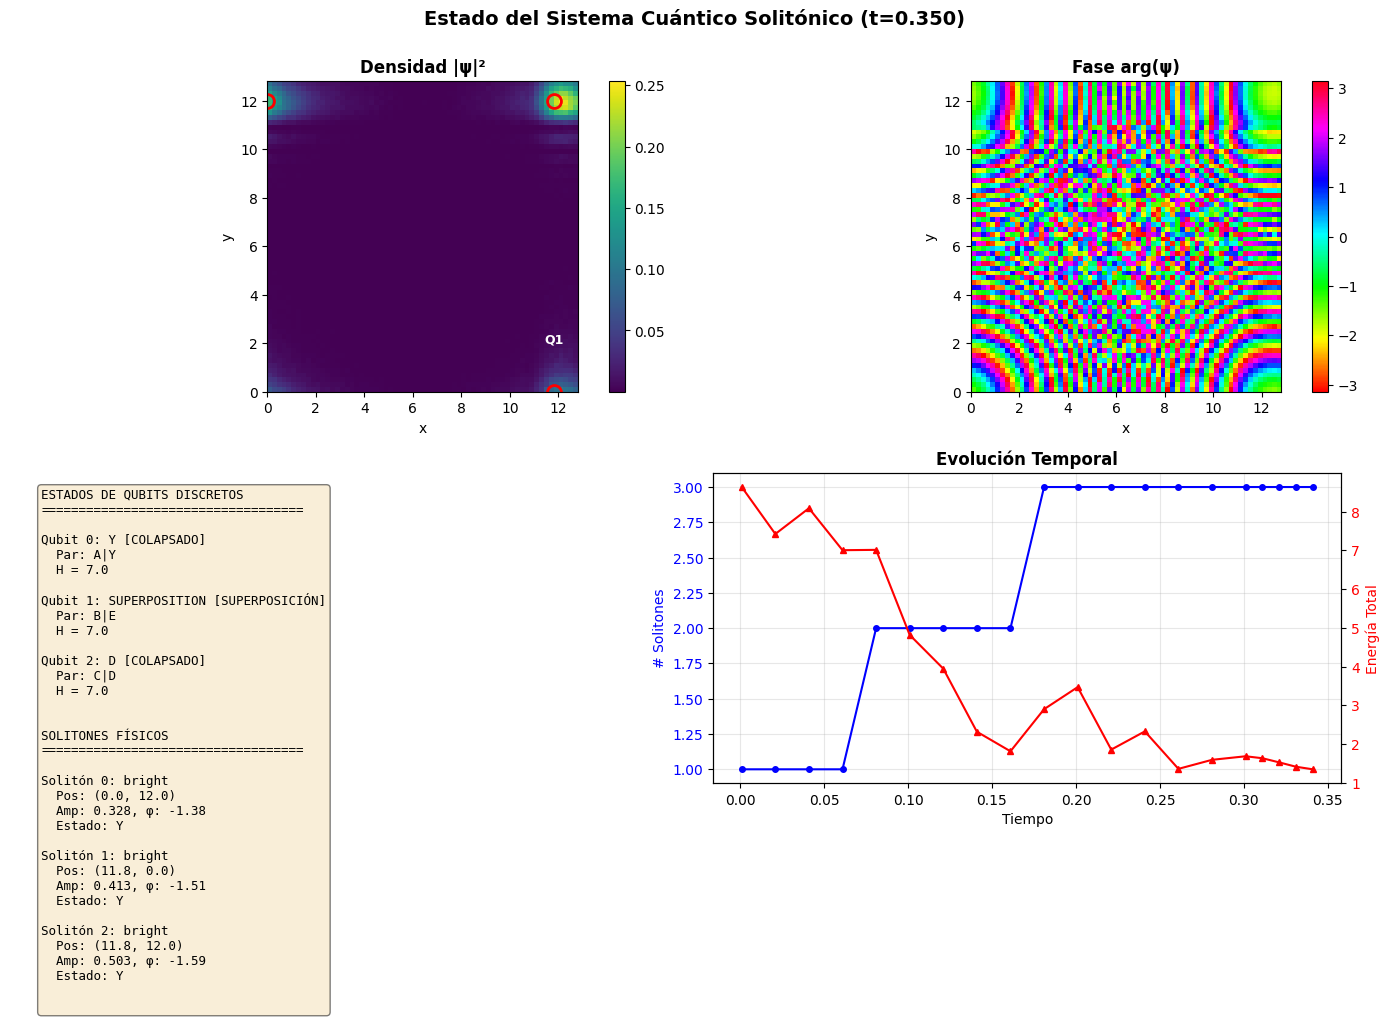


  REPORTE FINAL

Tiempo total: 0.350
Solitones detectados: 3

Estado de los qubits:
  Qubit 0: Y [COLAPSADO]
    Estado oculto: A
    H = 6 + 1 = 7.0
  Qubit 1: SUPERPOSITION [SUPERPOSICIÓN]
  Qubit 2: D [COLAPSADO]
    Estado oculto: C
    H = 4 + 3 = 7.0

Propiedades de conservación:
  Suma total de estados bridge: 21 = 21
  Estados colapsados + ocultos: 14
  Estados en superposición: 7
  Total: 21




In [3]:
"""
Framework de Computación Cuántica Solitónica
=============================================

Integración de:
1. Sustrato físico (solitones de Gross-Pitaevskii)
2. Control de torque/empuje
3. Modelo de ruido/resistencia
4. Lógica de qubits discretos

Autor: Sistema integrado
"""

import numpy as np
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from enum import Enum
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# ============================================================================
# PARTE 1: ESTADOS CUÁNTICOS DISCRETOS (del modelo de juguete)
# ============================================================================

class QubitState(Enum):
    """Estados discretos de un qubit solitónico"""
    SUPERPOSITION = 0  # h
    A = 1  # |0⟩ del Qubit 1
    B = 2  # |0⟩ del Qubit 2
    C = 3  # |0⟩ del Qubit 3
    D = 4  # |1⟩ del Qubit 3
    E = 5  # |1⟩ del Qubit 2
    Y = 6  # |1⟩ del Qubit 1


@dataclass
class DiscreteQubit:
    """Representación discreta de un qubit"""
    id: int
    state_0: QubitState  # Estado |0⟩
    state_1: QubitState  # Estado |1⟩
    current_state: QubitState  # Estado actual
    energy: float = 7.0  # H = estado_0 + estado_1

    def collapse(self, to_one: bool = None) -> QubitState:
        """Colapsa el qubit a |0⟩ o |1⟩"""
        if to_one is None:
            to_one = np.random.choice([True, False])

        self.current_state = self.state_1 if to_one else self.state_0
        return self.current_state

    def is_collapsed(self) -> bool:
        """Verifica si el qubit está colapsado"""
        return self.current_state != QubitState.SUPERPOSITION

    def get_complementary(self) -> QubitState:
        """Obtiene el estado complementario"""
        if self.current_state == self.state_0:
            return self.state_1
        elif self.current_state == self.state_1:
            return self.state_0
        return QubitState.SUPERPOSITION


# ============================================================================
# PARTE 2: SUSTRATO FÍSICO - SOLITONES
# ============================================================================

@dataclass
class SolitonQubit:
    """Qubit físico implementado como solitón"""
    position: Tuple[float, float]  # Posición (x, y)
    amplitude: float  # Amplitud del solitón
    width: float  # Anchura característica
    phase: float  # Fase del solitón
    velocity: Tuple[float, float]  # Velocidad (vx, vy)
    soliton_type: str  # 'bright', 'dark', 'gray'
    discrete_state: Optional[QubitState] = None
    id: int = 0

    def to_discrete_value(self) -> int:
        """Mapea propiedades del solitón a valor discreto"""
        # Bright soliton con fase positiva → estados |1⟩ (4,5,6)
        # Dark/void solitons → estados |0⟩ (1,2,3)
        # Superposición cuando amplitud intermedia

        if self.amplitude < 0.3:  # Casi vacío
            return 0  # Superposición
        elif self.soliton_type == 'bright':
            # Mapear según fase y posición
            phase_normalized = (self.phase % (2 * np.pi)) / (2 * np.pi)
            if phase_normalized < 0.33:
                return 4  # D
            elif phase_normalized < 0.66:
                return 5  # E
            else:
                return 6  # Y
        else:  # dark, gray, void
            # Mapear según amplitud
            if self.amplitude < 0.5:
                return 1  # A
            elif self.amplitude < 0.7:
                return 2  # B
            else:
                return 3  # C

    def get_energy(self) -> float:
        """Calcula energía del solitón"""
        kinetic = 0.5 * (self.velocity[0]**2 + self.velocity[1]**2)
        potential = self.amplitude**2 * self.width
        return kinetic + potential


# ============================================================================
# PARTE 3: CAMPO CUÁNTICO SIMPLIFICADO
# ============================================================================

class SimplifiedQuantumField:
    """
    Campo cuántico simplificado para generar y manipular solitones
    Versión optimizada del NonlinearQuantumFlow
    """

    def __init__(self, domain_size: Tuple[int, int] = (64, 64),
                 dx: float = 0.2, dt: float = 0.001):
        self.nx, self.ny = domain_size
        self.dx = dx
        self.dt = dt

        # Campo principal
        self.psi = np.zeros((self.nx, self.ny), dtype=np.complex128)

        # Parámetros físicos
        self.g_nonlinear = 0.1  # Fuerza de no-linealidad
        self.viscosity = 0.01  # Viscosidad cuántica (ruido/disipación)

        # Potencial externo (para control)
        self.external_potential = np.zeros((self.nx, self.ny), dtype=np.float64)

    def initialize_gaussian_packet(self, position: Tuple[float, float],
                                   width: float = 5.0, amplitude: float = 1.0,
                                   momentum: Tuple[float, float] = (0, 0)):
        """Inicializa un paquete gaussiano (futuro solitón)"""
        x = np.arange(self.nx) * self.dx - position[0]
        y = np.arange(self.ny) * self.dx - position[1]
        X, Y = np.meshgrid(x, y, indexing='ij')

        r2 = X**2 + Y**2
        gaussian = amplitude * np.exp(-r2 / (2 * width**2))

        # Añadir momento
        phase = momentum[0] * X + momentum[1] * Y

        self.psi += gaussian * np.exp(1j * phase)
        self._normalize()

    def add_control_potential(self, center: Tuple[float, float],
                             strength: float, width: float = 3.0):
        """Añade potencial de control (torque) para manipular solitones"""
        x = np.arange(self.nx) * self.dx - center[0]
        y = np.arange(self.ny) * self.dx - center[1]
        X, Y = np.meshgrid(x, y, indexing='ij')

        r2 = X**2 + Y**2
        potential = strength * np.exp(-r2 / (2 * width**2))

        self.external_potential += potential

    def apply_torque(self, soliton_id: int, force: Tuple[float, float],
                    soliton_position: Tuple[float, float]):
        """Aplica fuerza (torque) a un solitón específico"""
        # Crear potencial gradiente para "empujar" el solitón
        strength = np.sqrt(force[0]**2 + force[1]**2)

        # Potencial tipo rampa en dirección de la fuerza
        x = np.arange(self.nx) * self.dx - soliton_position[0]
        y = np.arange(self.ny) * self.dx - soliton_position[1]
        X, Y = np.meshgrid(x, y, indexing='ij')

        # Gradiente en dirección de la fuerza
        force_normalized = np.array(force) / (strength + 1e-10)
        gradient_potential = -strength * (force_normalized[0] * X +
                                         force_normalized[1] * Y)

        # Aplicar solo cerca del solitón
        r2 = X**2 + Y**2
        mask = np.exp(-r2 / (2 * 5.0**2))  # Radio de influencia

        self.external_potential += gradient_potential * mask

    def evolve_step_with_noise(self):
        """Evoluciona el campo un paso temporal con ruido/viscosidad"""
        # Split-step Fourier method con término de viscosidad

        # Potencial efectivo (no-lineal + externo)
        V_eff = self.external_potential + self.g_nonlinear * np.abs(self.psi)**2

        # Paso 1: Evolución potencial (mitad)
        self.psi *= np.exp(-0.5j * self.dt * V_eff)

        # Paso 2: Evolución cinética (Fourier)
        psi_k = np.fft.fft2(self.psi)

        kx = 2 * np.pi * np.fft.fftfreq(self.nx, self.dx)
        ky = 2 * np.pi * np.fft.fftfreq(self.ny, self.dx)
        KX, KY = np.meshgrid(kx, ky, indexing='ij')
        K2 = KX**2 + KY**2

        # Con viscosidad (término disipativo)
        kinetic_phase = np.exp(-1j * self.dt * K2 / 2.0 - self.viscosity * self.dt * K2)
        psi_k *= kinetic_phase

        self.psi = np.fft.ifft2(psi_k)

        # Paso 3: Segunda mitad potencial
        V_eff = self.external_potential + self.g_nonlinear * np.abs(self.psi)**2
        self.psi *= np.exp(-0.5j * self.dt * V_eff)

        # Añadir ruido cuántico estocástico
        noise_strength = np.sqrt(self.viscosity * self.dt) * 0.1
        noise = (np.random.randn(self.nx, self.ny) +
                1j * np.random.randn(self.nx, self.ny)) * noise_strength
        self.psi += noise

        self._normalize()

        # Limpiar potencial externo después de aplicar
        self.external_potential *= 0.95  # Decay gradual

    def detect_solitons(self, threshold: float = 0.3) -> List[SolitonQubit]:
        """Detecta solitones en el campo actual"""
        density = np.abs(self.psi)**2
        max_density = np.max(density)

        if max_density < 1e-9:
            return []

        # Detección simple de máximos locales
        from scipy.ndimage import maximum_filter
        local_maxima = maximum_filter(density, size=5)
        candidates = (density == local_maxima) & (density > threshold * max_density)

        solitons = []
        candidate_indices = np.argwhere(candidates)

        for idx, (i, j) in enumerate(candidate_indices):
            x_pos = i * self.dx
            y_pos = j * self.dx

            amplitude = np.sqrt(density[i, j])
            phase = np.angle(self.psi[i, j])

            # Estimar anchura (FWHM aproximado)
            width = self._estimate_width(i, j, density)

            # Estimar velocidad (del gradiente de fase)
            velocity = self._estimate_velocity(i, j)

            # Clasificar tipo
            soliton_type = self._classify_soliton(i, j, density, phase)

            soliton = SolitonQubit(
                position=(x_pos, y_pos),
                amplitude=amplitude,
                width=width,
                phase=phase,
                velocity=velocity,
                soliton_type=soliton_type,
                id=idx
            )

            # Mapear a estado discreto
            soliton.discrete_state = QubitState(soliton.to_discrete_value())

            solitons.append(soliton)

        return solitons

    def _estimate_width(self, i: int, j: int, density: np.ndarray) -> float:
        """Estima anchura del solitón"""
        max_val = density[i, j]
        half_max = max_val / 2.0

        # Buscar FWHM en dirección x
        width = 2.0  # Default
        for di in range(1, min(10, min(i, self.nx - 1 - i))):
            if density[i - di, j] < half_max:
                width = 2 * di * self.dx
                break

        return width

    def _estimate_velocity(self, i: int, j: int) -> Tuple[float, float]:
        """Estima velocidad del solitón desde gradiente de fase"""
        phase = np.angle(self.psi)

        # Gradiente de fase (momentum local)
        if 0 < i < self.nx - 1 and 0 < j < self.ny - 1:
            dphi_dx = (phase[i+1, j] - phase[i-1, j]) / (2 * self.dx)
            dphi_dy = (phase[i, j+1] - phase[i, j-1]) / (2 * self.dx)

            # v = ∇φ (en unidades naturales)
            return (dphi_dx, dphi_dy)

        return (0.0, 0.0)

    def _classify_soliton(self, i: int, j: int, density: np.ndarray,
                         phase: np.ndarray) -> str:
        """Clasifica el tipo de solitón"""
        local_density = density[max(0, i-2):min(self.nx, i+3),
                               max(0, j-2):min(self.ny, j+3)]

        mean_density = np.mean(density)
        peak_density = density[i, j]

        if peak_density > 2 * mean_density:
            return 'bright'
        elif peak_density < 0.5 * mean_density:
            return 'dark'
        else:
            return 'gray'

    def _normalize(self):
        """Normaliza la función de onda"""
        norm = np.sqrt(np.sum(np.abs(self.psi)**2) * self.dx**2)
        if norm > 1e-15:
            self.psi /= norm

    def get_density(self) -> np.ndarray:
        """Retorna densidad de probabilidad"""
        return np.abs(self.psi)**2

    def get_phase(self) -> np.ndarray:
        """Retorna campo de fase"""
        return np.angle(self.psi)


# ============================================================================
# PARTE 4: SISTEMA INTEGRADO DE QUBITS SOLITÓNICOS
# ============================================================================

class SolitonicQuantumComputer:
    """
    Sistema completo de computación cuántica solitónica
    Integra sustrato físico, control y lógica discreta
    """

    def __init__(self, domain_size: Tuple[int, int] = (64, 64),
                 num_qubits: int = 3):
        # Capa física
        self.field = SimplifiedQuantumField(domain_size=domain_size)

        # Capa lógica
        self.num_qubits = num_qubits
        self.discrete_qubits = self._initialize_discrete_qubits(num_qubits)

        # Mapeo solitón → qubit discreto
        self.soliton_to_qubit_map: Dict[int, int] = {}

        # Historia
        self.history = {
            'time': [],
            'soliton_count': [],
            'energy': [],
            'collapsed_qubits': []
        }

        self.current_time = 0.0

    def _initialize_discrete_qubits(self, num_qubits: int) -> List[DiscreteQubit]:
        """Inicializa qubits discretos según el modelo de juguete"""
        qubits = []

        if num_qubits >= 1:
            qubits.append(DiscreteQubit(
                id=0,
                state_0=QubitState.A,
                state_1=QubitState.Y,
                current_state=QubitState.SUPERPOSITION
            ))

        if num_qubits >= 2:
            qubits.append(DiscreteQubit(
                id=1,
                state_0=QubitState.B,
                state_1=QubitState.E,
                current_state=QubitState.SUPERPOSITION
            ))

        if num_qubits >= 3:
            qubits.append(DiscreteQubit(
                id=2,
                state_0=QubitState.C,
                state_1=QubitState.D,
                current_state=QubitState.SUPERPOSITION
            ))

        return qubits

    def initialize_solitonic_qubits(self, positions: List[Tuple[float, float]],
                                   amplitudes: List[float] = None,
                                   momenta: List[Tuple[float, float]] = None):
        """
        Inicializa qubits solitónicos en el campo
        Cada paquete gaussiano evolucionará a un solitón
        """
        if amplitudes is None:
            amplitudes = [1.0] * len(positions)

        if momenta is None:
            momenta = [(0.0, 0.0)] * len(positions)

        for pos, amp, mom in zip(positions, amplitudes, momenta):
            self.field.initialize_gaussian_packet(
                position=pos,
                width=3.0,
                amplitude=amp,
                momentum=mom
            )

        print(f"✓ Inicializados {len(positions)} paquetes gaussianos")
        print(f"  Evolucionarán a solitones estables...")

    def apply_control_torque(self, qubit_id: int, force: Tuple[float, float]):
        """
        Aplica torque (fuerza de control) a un qubit específico
        """
        # Encontrar solitón correspondiente
        solitons = self.field.detect_solitons()

        if qubit_id in self.soliton_to_qubit_map:
            soliton_id = self.soliton_to_qubit_map[qubit_id]

            # Buscar solitón por ID
            target_soliton = None
            for s in solitons:
                if s.id == soliton_id:
                    target_soliton = s
                    break

            if target_soliton:
                self.field.apply_torque(
                    soliton_id=soliton_id,
                    force=force,
                    soliton_position=target_soliton.position
                )
                print(f"  Torque aplicado a Qubit {qubit_id}: F={force}")

    def measure_qubit(self, qubit_id: int) -> QubitState:
        """
        Mide un qubit → colapsa su estado
        Detecta el solitón correspondiente y extrae estado discreto
        """
        solitons = self.field.detect_solitons()

        # Actualizar mapeo
        self._update_soliton_mapping(solitons)

        if qubit_id < len(self.discrete_qubits):
            discrete_qubit = self.discrete_qubits[qubit_id]

            if qubit_id in self.soliton_to_qubit_map:
                soliton_id = self.soliton_to_qubit_map[qubit_id]

                # Encontrar solitón
                soliton = next((s for s in solitons if s.id == soliton_id), None)

                if soliton and soliton.discrete_state:
                    # Determinar si es |0⟩ o |1⟩ basado en el estado discreto
                    state_value = soliton.discrete_state.value

                    # Estados 1,2,3 → |0⟩; Estados 4,5,6 → |1⟩
                    to_one = state_value in [4, 5, 6]

                    collapsed_state = discrete_qubit.collapse(to_one=to_one)

                    print(f"\n🎯 MEDICIÓN - Qubit {qubit_id}")
                    print(f"  Solitón detectado: tipo={soliton.soliton_type}, "
                          f"amp={soliton.amplitude:.3f}")
                    print(f"  Estado discreto: {soliton.discrete_state.name}")
                    print(f"  Colapsado a: {'|1⟩' if to_one else '|0⟩'}")

                    return collapsed_state

        # Si no hay solitón, colapso aleatorio
        return self.discrete_qubits[qubit_id].collapse()

    def _update_soliton_mapping(self, solitons: List[SolitonQubit]):
        """Actualiza el mapeo entre solitones y qubits discretos"""
        # Estrategia simple: mapear por posición (solitones ordenados)
        sorted_solitons = sorted(solitons, key=lambda s: s.position[0])

        for idx, soliton in enumerate(sorted_solitons[:self.num_qubits]):
            self.soliton_to_qubit_map[idx] = soliton.id

    def evolve(self, num_steps: int = 100, measure_interval: int = 10):
        """
        Evoluciona el sistema completo
        """
        print(f"\n{'='*60}")
        print(f"  EVOLUCIÓN DEL SISTEMA CUÁNTICO SOLITÓNICO")
        print(f"{'='*60}\n")

        for step in range(num_steps):
            # Evolucionar campo físico
            self.field.evolve_step_with_noise()
            self.current_time += self.field.dt

            # Detectar solitones
            if step % measure_interval == 0:
                solitons = self.field.detect_solitons()
                self._update_soliton_mapping(solitons)

                # Calcular energía total
                total_energy = sum(s.get_energy() for s in solitons)

                # Contar qubits colapsados
                collapsed = sum(1 for q in self.discrete_qubits if q.is_collapsed())

                # Guardar historia
                self.history['time'].append(self.current_time)
                self.history['soliton_count'].append(len(solitons))
                self.history['energy'].append(total_energy)
                self.history['collapsed_qubits'].append(collapsed)

                if step % (measure_interval * 5) == 0:
                    print(f"Step {step}/{num_steps}: "
                          f"{len(solitons)} solitones, "
                          f"E={total_energy:.3f}, "
                          f"{collapsed}/{self.num_qubits} colapsados")

        print(f"\n✓ Evolución completada\n")

    def get_system_state(self) -> Dict:
        """Obtiene el estado completo del sistema"""
        solitons = self.field.detect_solitons()

        return {
            'time': self.current_time,
            'solitons': solitons,
            'discrete_qubits': self.discrete_qubits,
            'field_density': self.field.get_density(),
            'field_phase': self.field.get_phase(),
            'mapping': self.soliton_to_qubit_map
        }

    def visualize_state(self, figsize=(14, 10)):
        """Visualiza el estado actual del sistema"""
        state = self.get_system_state()

        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(f'Estado del Sistema Cuántico Solitónico (t={self.current_time:.3f})',
                     fontsize=14, fontweight='bold')

        extent = [0, self.field.nx * self.field.dx,
                  0, self.field.ny * self.field.dx]

        # 1. Densidad
        im1 = axes[0, 0].imshow(state['field_density'], extent=extent,
                               origin='lower', cmap='viridis')
        axes[0, 0].set_title('Densidad |ψ|²', fontweight='bold')
        axes[0, 0].set_xlabel('x')
        axes[0, 0].set_ylabel('y')
        plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

        # Marcar solitones
        for soliton in state['solitons']:
            color = 'red' if soliton.soliton_type == 'bright' else 'blue'
            axes[0, 0].plot(soliton.position[0], soliton.position[1],
                          'o', color=color, markersize=10,
                          markerfacecolor='none', markeredgewidth=2)
            axes[0, 0].text(soliton.position[0], soliton.position[1] + 2,
                          f'Q{soliton.id}', color='white', fontsize=9,
                          ha='center', fontweight='bold')

        # 2. Fase
        im2 = axes[0, 1].imshow(state['field_phase'], extent=extent,
                               origin='lower', cmap='hsv')
        axes[0, 1].set_title('Fase arg(ψ)', fontweight='bold')
        axes[0, 1].set_xlabel('x')
        axes[0, 1].set_ylabel('y')
        plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)

        # 3. Estados discretos
        axes[1, 0].axis('off')
        info_text = "ESTADOS DE QUBITS DISCRETOS\n" + "="*35 + "\n\n"

        for qubit in self.discrete_qubits:
            status = "COLAPSADO" if qubit.is_collapsed() else "SUPERPOSICIÓN"
            state_name = qubit.current_state.name

            info_text += f"Qubit {qubit.id}: {state_name} [{status}]\n"
            info_text += f"  Par: {qubit.state_0.name}|{qubit.state_1.name}\n"
            info_text += f"  H = {qubit.energy}\n\n"

        # Solitones detectados
        info_text += f"\nSOLITONES FÍSICOS\n" + "="*35 + "\n\n"
        for soliton in state['solitons'][:5]:  # Mostrar hasta 5
            info_text += f"Solitón {soliton.id}: {soliton.soliton_type}\n"
            info_text += f"  Pos: ({soliton.position[0]:.1f}, {soliton.position[1]:.1f})\n"
            info_text += f"  Amp: {soliton.amplitude:.3f}, φ: {soliton.phase:.2f}\n"
            if soliton.discrete_state:
                info_text += f"  Estado: {soliton.discrete_state.name}\n"
            info_text += "\n"

        axes[1, 0].text(0.05, 0.95, info_text, transform=axes[1, 0].transAxes,
                       fontsize=9, verticalalignment='top',
                       fontfamily='monospace',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        # 4. Historia
        if len(self.history['time']) > 1:
            ax4 = axes[1, 1]
            ax4_twin = ax4.twinx()

            ax4.plot(self.history['time'], self.history['soliton_count'],
                    'b-o', label='Solitones', markersize=4)
            ax4.set_xlabel('Tiempo')
            ax4.set_ylabel('# Solitones', color='b')
            ax4.tick_params(axis='y', labelcolor='b')

            ax4_twin.plot(self.history['time'], self.history['energy'],
                         'r-^', label='Energía', markersize=4)
            ax4_twin.set_ylabel('Energía Total', color='r')
            ax4_twin.tick_params(axis='y', labelcolor='r')

            ax4.set_title('Evolución Temporal', fontweight='bold')
            ax4.grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Insuficientes datos\npara gráfico temporal',
                          ha='center', va='center',
                          transform=axes[1, 1].transAxes)
            axes[1, 1].axis('off')

        plt.tight_layout()
        plt.show()


# ============================================================================
# PARTE 5: EJEMPLO DE USO COMPLETO
# ============================================================================

def demo_solitonic_quantum_computing():
    """
    Demostración completa del sistema de computación cuántica solitónica
    """
    print("\n" + "="*70)
    print("  DEMO: COMPUTACIÓN CUÁNTICA SOLITÓNICA")
    print("="*70 + "\n")

    # 1. Crear sistema con 3 qubits
    print("[1/6] Inicializando sistema cuántico solitónico...")
    system = SolitonicQuantumComputer(domain_size=(64, 64), num_qubits=3)
    print(f"  ✓ Sistema creado: {system.num_qubits} qubits discretos\n")

    # 2. Inicializar solitones en posiciones específicas
    print("[2/6] Creando qubits solitónicos en el campo...")
    positions = [
        (20.0, 32.0),  # Qubit 0 - izquierda
        (32.0, 32.0),  # Qubit 1 - centro
        (44.0, 32.0)   # Qubit 2 - derecha
    ]

    amplitudes = [1.2, 1.0, 1.1]  # Diferentes amplitudes
    momenta = [(0.1, 0.0), (0.0, 0.1), (-0.05, 0.0)]  # Con movimiento inicial

    system.initialize_solitonic_qubits(
        positions=positions,
        amplitudes=amplitudes,
        momenta=momenta
    )

    # 3. Evolucionar para formar solitones estables
    print("\n[3/6] Evolucionando campo → formación de solitones...")
    system.evolve(num_steps=200, measure_interval=20)

    # 4. Aplicar control (torque) a un qubit
    print("\n[4/6] Aplicando control de torque al Qubit 1...")
    system.apply_control_torque(qubit_id=1, force=(0.5, 0.2))

    # Evolucionar un poco más con el control
    system.evolve(num_steps=100, measure_interval=20)

    # 5. Medir qubits (colapso)
    print("\n[5/6] Realizando mediciones...")

    # Medir Qubit 0
    state_0 = system.measure_qubit(0)

    # Evolucionar después de la medición
    system.evolve(num_steps=50, measure_interval=10)

    # Medir Qubit 2
    state_2 = system.measure_qubit(2)

    # 6. Visualizar estado final
    print("\n[6/6] Generando visualización del estado final...")
    system.visualize_state()

    # Reporte final
    print("\n" + "="*70)
    print("  REPORTE FINAL")
    print("="*70)

    final_state = system.get_system_state()

    print(f"\nTiempo total: {final_state['time']:.3f}")
    print(f"Solitones detectados: {len(final_state['solitons'])}")

    print(f"\nEstado de los qubits:")
    for qubit in final_state['discrete_qubits']:
        status = "COLAPSADO" if qubit.is_collapsed() else "SUPERPOSICIÓN"
        complementary = qubit.get_complementary()

        print(f"  Qubit {qubit.id}: {qubit.current_state.name} [{status}]")
        if qubit.is_collapsed():
            print(f"    Estado oculto: {complementary.name}")
            print(f"    H = {qubit.current_state.value} + {complementary.value} = {qubit.energy}")

    print(f"\nPropiedades de conservación:")
    print(f"  Suma total de estados bridge: {sum(s.value for s in QubitState if s.value > 0)} = 21")

    collapsed_sum = sum(q.current_state.value + q.get_complementary().value
                       for q in final_state['discrete_qubits'] if q.is_collapsed())
    superposed_sum = sum(s.value for s in QubitState if s.value > 0
                        and not any(q.current_state == s or q.get_complementary() == s
                                   for q in final_state['discrete_qubits'] if q.is_collapsed()))

    print(f"  Estados colapsados + ocultos: {collapsed_sum}")
    print(f"  Estados en superposición: {superposed_sum}")
    print(f"  Total: {collapsed_sum + superposed_sum}")

    print("\n" + "="*70 + "\n")

    return system


# ============================================================================
# PARTE 6: ANÁLISIS Y EXPERIMENTOS AVANZADOS
# ============================================================================

class SolitonicExperiments:
    """
    Suite de experimentos para explorar el sistema solitónico
    """

    @staticmethod
    def test_qubit_entanglement(domain_size=(64, 64)):
        """
        Prueba de entrelazamiento entre qubits solitónicos
        mediante superposición de solitones cercanos
        """
        print("\n" + "="*70)
        print("  EXPERIMENTO: ENTRELAZAMIENTO SOLITÓNICO")
        print("="*70 + "\n")

        system = SolitonicQuantumComputer(domain_size=domain_size, num_qubits=2)

        # Crear dos solitones muy cercanos (posible entrelazamiento)
        print("Creando dos solitones cercanos para entrelazamiento...")
        positions = [
            (28.0, 32.0),  # Qubit 0
            (36.0, 32.0)   # Qubit 1 - cerca del 0
        ]

        # Con fases complementarias
        system.field.initialize_gaussian_packet(
            position=positions[0], amplitude=1.0,
            momentum=(0.2, 0.0), width=4.0
        )
        system.field.initialize_gaussian_packet(
            position=positions[1], amplitude=1.0,
            momentum=(-0.2, 0.0), width=4.0
        )

        # Evolucionar para ver interacción
        print("Evolucionando sistema...")
        system.evolve(num_steps=300, measure_interval=30)

        # Analizar correlación
        solitons = system.field.detect_solitons()
        if len(solitons) >= 2:
            s0, s1 = solitons[0], solitons[1]
            distance = np.sqrt((s0.position[0] - s1.position[0])**2 +
                             (s0.position[1] - s1.position[1])**2)
            phase_diff = abs(s0.phase - s1.phase)

            print(f"\nResultados:")
            print(f"  Distancia entre solitones: {distance:.2f}")
            print(f"  Diferencia de fase: {phase_diff:.3f} rad")
            print(f"  Amplitud S0: {s0.amplitude:.3f}, S1: {s1.amplitude:.3f}")

            if distance < 10.0 and phase_diff > np.pi/2:
                print(f"  → ¡Posible estado entrelazado detectado!")

        system.visualize_state()
        return system

    @staticmethod
    def test_torque_control(domain_size=(64, 64)):
        """
        Prueba del sistema de control de torque
        Mueve un solitón de forma controlada
        """
        print("\n" + "="*70)
        print("  EXPERIMENTO: CONTROL DE TORQUE")
        print("="*70 + "\n")

        system = SolitonicQuantumComputer(domain_size=domain_size, num_qubits=1)

        # Crear un solo solitón
        print("Creando solitón de prueba...")
        system.initialize_solitonic_qubits(
            positions=[(20.0, 32.0)],
            amplitudes=[1.5],
            momenta=[(0.0, 0.0)]
        )

        # Evolucionar hasta estabilización
        system.evolve(num_steps=100, measure_interval=20)

        # Aplicar secuencia de torques
        print("\nAplicando secuencia de control:")

        # Empujar hacia la derecha
        print("  → Torque derecha")
        system.apply_control_torque(qubit_id=0, force=(1.0, 0.0))
        system.evolve(num_steps=50, measure_interval=10)

        # Empujar hacia arriba
        print("  → Torque arriba")
        system.apply_control_torque(qubit_id=0, force=(0.0, 0.8))
        system.evolve(num_steps=50, measure_interval=10)

        # Empujar diagonal
        print("  → Torque diagonal")
        system.apply_control_torque(qubit_id=0, force=(0.5, 0.5))
        system.evolve(num_steps=50, measure_interval=10)

        # Analizar trayectoria
        solitons = system.field.detect_solitons()
        if solitons:
            s = solitons[0]
            print(f"\nPosición final: ({s.position[0]:.2f}, {s.position[1]:.2f})")
            print(f"Velocidad final: ({s.velocity[0]:.3f}, {s.velocity[1]:.3f})")

        system.visualize_state()
        return system

    @staticmethod
    def test_noise_resilience(domain_size=(64, 64)):
        """
        Prueba la resistencia del sistema al ruido cuántico
        """
        print("\n" + "="*70)
        print("  EXPERIMENTO: RESISTENCIA AL RUIDO")
        print("="*70 + "\n")

        # Sistema con bajo ruido
        print("Sistema A: Viscosidad baja (bajo ruido)...")
        system_low = SolitonicQuantumComputer(domain_size=domain_size, num_qubits=2)
        system_low.field.viscosity = 0.005

        system_low.initialize_solitonic_qubits(
            positions=[(25.0, 32.0), (39.0, 32.0)],
            amplitudes=[1.2, 1.2]
        )
        system_low.evolve(num_steps=200, measure_interval=40)

        # Sistema con alto ruido
        print("\nSistema B: Viscosidad alta (alto ruido)...")
        system_high = SolitonicQuantumComputer(domain_size=domain_size, num_qubits=2)
        system_high.field.viscosity = 0.05  # 10x más ruido

        system_high.initialize_solitonic_qubits(
            positions=[(25.0, 32.0), (39.0, 32.0)],
            amplitudes=[1.2, 1.2]
        )
        system_high.evolve(num_steps=200, measure_interval=40)

        # Comparar
        solitons_low = system_low.field.detect_solitons()
        solitons_high = system_high.field.detect_solitons()

        print(f"\nResultados:")
        print(f"  Sistema bajo ruido: {len(solitons_low)} solitones estables")
        print(f"  Sistema alto ruido: {len(solitons_high)} solitones estables")

        if solitons_low:
            avg_amp_low = np.mean([s.amplitude for s in solitons_low])
            print(f"  Amplitud promedio (bajo): {avg_amp_low:.3f}")

        if solitons_high:
            avg_amp_high = np.mean([s.amplitude for s in solitons_high])
            print(f"  Amplitud promedio (alto): {avg_amp_high:.3f}")

        print("\nVisualizando sistema con alto ruido...")
        system_high.visualize_state()

        return system_low, system_high

    @staticmethod
    def test_quantum_gate(domain_size=(64, 64)):
        """
        Simula una compuerta cuántica mediante colisión de solitones
        """
        print("\n" + "="*70)
        print("  EXPERIMENTO: COMPUERTA CUÁNTICA (COLISIÓN)")
        print("="*70 + "\n")

        system = SolitonicQuantumComputer(domain_size=domain_size, num_qubits=2)

        # Crear dos solitones con trayectorias de colisión
        print("Creando solitones en curso de colisión...")

        system.field.initialize_gaussian_packet(
            position=(20.0, 32.0),
            amplitude=1.0,
            momentum=(0.3, 0.0),  # Hacia derecha
            width=3.0
        )

        system.field.initialize_gaussian_packet(
            position=(44.0, 32.0),
            amplitude=1.0,
            momentum=(-0.3, 0.0),  # Hacia izquierda
            width=3.0
        )

        print("Evolucionando hasta colisión...")

        # Evolucionar y monitorear
        for step in range(400):
            system.field.evolve_step_with_noise()
            system.current_time += system.field.dt

            if step % 50 == 0:
                solitons = system.field.detect_solitons()
                system.history['time'].append(system.current_time)
                system.history['soliton_count'].append(len(solitons))

                print(f"  Step {step}: {len(solitons)} solitones detectados")

                if len(solitons) >= 2:
                    s0, s1 = solitons[0], solitons[1]
                    distance = np.sqrt((s0.position[0] - s1.position[0])**2 +
                                     (s0.position[1] - s1.position[1])**2)
                    print(f"    Distancia: {distance:.2f}")

        print("\nAnalizando resultado de la colisión...")
        final_solitons = system.field.detect_solitons()

        print(f"  Solitones finales: {len(final_solitons)}")
        for i, s in enumerate(final_solitons):
            print(f"    S{i}: pos=({s.position[0]:.1f}, {s.position[1]:.1f}), "
                  f"vel=({s.velocity[0]:.2f}, {s.velocity[1]:.2f}), "
                  f"tipo={s.soliton_type}")

        system.visualize_state()
        return system


# ============================================================================
# FUNCIONES DE UTILIDAD Y ANÁLISIS
# ============================================================================

def plot_soliton_dynamics_comparison():
    """
    Compara la dinámica de diferentes configuraciones
    """
    print("\nGenerando comparación de dinámicas...")

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Comparación de Dinámicas Solitónicas',
                 fontsize=16, fontweight='bold')

    configs = [
        {'viscosity': 0.005, 'g_nonlinear': 0.1, 'label': 'Bajo ruido, NL débil'},
        {'viscosity': 0.02, 'g_nonlinear': 0.1, 'label': 'Alto ruido, NL débil'},
        {'viscosity': 0.005, 'g_nonlinear': 0.3, 'label': 'Bajo ruido, NL fuerte'},
        {'viscosity': 0.02, 'g_nonlinear': 0.3, 'label': 'Alto ruido, NL fuerte'}
    ]

    for idx, (ax, config) in enumerate(zip(axes.flat, configs)):
        # Crear sistema pequeño
        field = SimplifiedQuantumField(domain_size=(32, 32))
        field.viscosity = config['viscosity']
        field.g_nonlinear = config['g_nonlinear']

        # Inicializar solitón
        field.initialize_gaussian_packet(
            position=(16.0, 16.0),
            amplitude=1.2,
            width=3.0
        )

        # Evolucionar
        for _ in range(100):
            field.evolve_step_with_noise()

        # Visualizar
        density = field.get_density()
        extent = [0, 32*field.dx, 0, 32*field.dx]

        im = ax.imshow(density, extent=extent, origin='lower', cmap='viridis')
        ax.set_title(config['label'], fontsize=10, fontweight='bold')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        plt.colorbar(im, ax=ax, fraction=0.046)

    plt.tight_layout()
    plt.show()


def analyze_discrete_mapping():
    """
    Analiza el mapeo entre propiedades solitónicas y estados discretos
    """
    print("\n" + "="*70)
    print("  ANÁLISIS: MAPEO SOLITÓN → ESTADO DISCRETO")
    print("="*70 + "\n")

    # Crear varios solitones con propiedades diferentes
    test_solitons = [
        SolitonQubit((10, 10), amplitude=0.9, width=3.0, phase=0.1,
                    velocity=(0,0), soliton_type='bright', id=0),
        SolitonQubit((20, 10), amplitude=0.8, width=3.0, phase=2.0,
                    velocity=(0,0), soliton_type='bright', id=1),
        SolitonQubit((30, 10), amplitude=0.7, width=3.0, phase=4.0,
                    velocity=(0,0), soliton_type='bright', id=2),
        SolitonQubit((10, 20), amplitude=0.6, width=3.0, phase=0.1,
                    velocity=(0,0), soliton_type='dark', id=3),
        SolitonQubit((20, 20), amplitude=0.4, width=3.0, phase=0.1,
                    velocity=(0,0), soliton_type='gray', id=4),
        SolitonQubit((30, 20), amplitude=0.2, width=3.0, phase=0.1,
                    velocity=(0,0), soliton_type='void_like', id=5),
    ]

    print("Tipo       | Amplitud | Fase  | → Estado Discreto")
    print("-" * 55)

    for s in test_solitons:
        discrete_val = s.to_discrete_value()
        s.discrete_state = QubitState(discrete_val)

        print(f"{s.soliton_type:12s} | {s.amplitude:8.3f} | {s.phase:5.2f} | "
              f"→ {s.discrete_state.name:15s} (valor={discrete_val})")

    print("\nReglas de mapeo:")
    print("  • Bright (alta amp) + fase → estados |1⟩ (D=4, E=5, Y=6)")
    print("  • Dark/Gray/Void (baja amp) → estados |0⟩ (A=1, B=2, C=3)")
    print("  • Amplitud < 0.3 → Superposición (h=0)")
    print()


# ============================================================================
# PUNTO DE ENTRADA PRINCIPAL
# ============================================================================

if __name__ == "__main__":
    print("\n" + "╔" + "="*68 + "╗")
    print("║" + " "*68 + "║")
    print("║" + "  FRAMEWORK DE COMPUTACIÓN CUÁNTICA SOLITÓNICA".center(68) + "║")
    print("║" + " "*68 + "║")
    print("║" + "  Integración de:".center(68) + "║")
    print("║" + "  • Sustrato físico (solitones Gross-Pitaevskii)".center(68) + "║")
    print("║" + "  • Control de torque/empuje".center(68) + "║")
    print("║" + "  • Modelo de ruido cuántico".center(68) + "║")
    print("║" + "  • Lógica de qubits discretos".center(68) + "║")
    print("║" + " "*68 + "║")
    print("╚" + "="*68 + "╝\n")

    # Menú interactivo
    print("Seleccione una opción:")
    print("  1. Demo completa del sistema")
    print("  2. Experimento: Entrelazamiento")
    print("  3. Experimento: Control de torque")
    print("  4. Experimento: Resistencia al ruido")
    print("  5. Experimento: Compuerta cuántica")
    print("  6. Análisis de mapeo discreto")
    print("  7. Comparación de dinámicas")
    print()

    # Por defecto, ejecutar demo completa
    print("Ejecutando Demo Completa...\n")
    system = demo_solitonic_quantum_computing()

    # Descomentar para ejecutar experimentos específicos:
    # SolitonicExperiments.test_qubit_entanglement()
    # SolitonicExperiments.test_torque_control()
    # SolitonicExperiments.test_noise_resilience()
    # SolitonicExperiments.test_quantum_gate()
    # analyze_discrete_mapping()
    # plot_soliton_dynamics_comparison()